#### Import Libraries

In [1]:
import findspark
findspark.init()

In [2]:
# import libraries 

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import plotly.graph_objs as go 
from plotly.subplots import make_subplots

from datetime import datetime, timedelta

from pyspark.sql import SparkSession

import pyspark.sql.functions as F
from pyspark.sql import Window
from pyspark.sql.functions import avg, concat, countDistinct,\
    col, datediff, date_format, desc, \
    format_number, isnan, lag, lit, udf, split

from pyspark.ml import Pipeline 
from pyspark.ml.feature import MinMaxScaler, StringIndexer, VectorAssembler 
from pyspark.sql.types import StructField, StructType, IntegerType, FloatType, StringType

from pyspark.sql.functions import split 
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier 
from pyspark.ml.evaluation  import MulticlassClassificationEvaluator 
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [3]:
# create Spark Session 
spark = SparkSession \
    .builder \
    .appName("Sparkify_churn1")\
    .getOrCreate()

#### 1. Load Dataset

In [4]:
### Load the dataset
path = 'mini_sparkify_event_data.json'
df = spark.read.json(path)

In [5]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
df.count()

286500

In [7]:
df.limit(5).toPandas()

artist       auth firstName gender  itemInSession lastName  \
0    Martha Tilston  Logged In     Colin      M             50  Freeman   
1  Five Iron Frenzy  Logged In     Micah      M             79     Long   
2      Adam Lambert  Logged In     Colin      M             51  Freeman   
3            Enigma  Logged In     Micah      M             80     Long   
4         Daft Punk  Logged In     Colin      M             52  Freeman   

      length level                        location method      page  \
0  277.89016  paid                 Bakersfield, CA    PUT  NextSong   
1  236.09424  free  Boston-Cambridge-Newton, MA-NH    PUT  NextSong   
2  282.82730  paid                 Bakersfield, CA    PUT  NextSong   
3  262.71302  free  Boston-Cambridge-Newton, MA-NH    PUT  NextSong   
4  223.60771  paid                 Bakersfield, CA    PUT  NextSong   

    registration  sessionId                           song  status  \
0  1538173362000         29                      Rockpools     200   
1  1538331630000          8                         Canada     200   
2  1538173362000         29              Time For Miracles     200   
3  1538331630000          8    Knocking On Forbidden Doors     200   
4  1538173362000         29  Harder Better Faster Stronger     200   

              ts                                          userAgent userId  
0  1538352117000  Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...     30  
1  1538352180000  "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...      9  
2  1538352394000  Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...     30  
3  1538352416000  "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...      9  
4  1538352676000  Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...     30

In [8]:
df.dtypes

[('artist', 'string'),
 ('auth', 'string'),
 ('firstName', 'string'),
 ('gender', 'string'),
 ('itemInSession', 'bigint'),
 ('lastName', 'string'),
 ('length', 'double'),
 ('level', 'string'),
 ('location', 'string'),
 ('method', 'string'),
 ('page', 'string'),
 ('registration', 'bigint'),
 ('sessionId', 'bigint'),
 ('song', 'string'),
 ('status', 'bigint'),
 ('ts', 'bigint'),
 ('userAgent', 'string'),
 ('userId', 'string')]

#### Column Split: Categorical  vs Numerical
    => 데이터프레임의 각 컬럼을 분류해준다 

In [9]:
categorical_cols = []
numerical_cols = []


for i in range(len(df.dtypes)):
    if df.dtypes[i][1] == 'string':
        categorical_cols.append(df.dtypes[i][0])
        
    else:
        numerical_cols.append(df.dtypes[i][0])

print("Categorical columns:{}".format(categorical_cols))
print("Numerical columns : {}".format(numerical_cols))

Categorical columns:['artist', 'auth', 'firstName', 'gender', 'lastName', 'level', 'location', 'method', 'page', 'song', 'userAgent', 'userId']
Numerical columns : ['itemInSession', 'length', 'registration', 'sessionId', 'status', 'ts']


### Categorical Columns
- auth
- gender 
- level 
- location 
- method 
-page
-userAgent 
-userId

=> 각 컬럼에 데이터를 이해하기 위해서 고유의 데이터들을 확인해본다

In [10]:
# auth 
df.select("auth").distinct().show()

+----------+
|      auth|
+----------+
|Logged Out|
| Cancelled|
| Logged In|
|     Guest|
+----------+



In [11]:
# gender 
df.select("gender").distinct().show()

+------+
|gender|
+------+
|     F|
|  null|
|     M|
+------+



In [12]:
# level 
df.select("level").distinct().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [13]:
# location 
df.select("location").distinct().show(), df.select("location").distinct().count()

+--------------------+
|            location|
+--------------------+
|     Gainesville, FL|
|Atlantic City-Ham...|
|Deltona-Daytona B...|
|Kingsport-Bristol...|
|New Haven-Milford...|
|         Dubuque, IA|
|Las Vegas-Henders...|
|Indianapolis-Carm...|
|Seattle-Tacoma-Be...|
|   Winston-Salem, NC|
|     Bakersfield, CA|
|Los Angeles-Long ...|
|Minneapolis-St. P...|
|San Francisco-Oak...|
|Phoenix-Mesa-Scot...|
|Allentown-Bethleh...|
|Miami-Fort Lauder...|
|           Selma, AL|
|          Dayton, OH|
|Bridgeport-Stamfo...|
+--------------------+
only showing top 20 rows



(None, 115)

In [14]:
# method 
df.select("method").distinct().show()

+------+
|method|
+------+
|   PUT|
|   GET|
+------+



In [15]:
# page 
df.select("page").distinct().show(), df.select("page").distinct().count()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|               Login|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+
only showing top 20 rows



(None, 22)

In [16]:
# userAgent 
df.select("userAgent").distinct().show()

+--------------------+
|           userAgent|
+--------------------+
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (X11;...|
|"Mozilla/5.0 (Mac...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (comp...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (Maci...|
|                null|
|"Mozilla/5.0 (iPh...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (comp...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Win...|
|"Mozilla/5.0 (Win...|
|"Mozilla/5.0 (iPa...|
|Mozilla/5.0 (Wind...|
|"Mozilla/5.0 (Mac...|
+--------------------+
only showing top 20 rows



In [17]:
# userId 
df.select("userId").distinct().show(), df.select("userId").distinct().count()

+------+
|userId|
+------+
|    51|
|   124|
|     7|
|    54|
|    15|
|   132|
|   101|
|    11|
|   138|
|    29|
|    69|
|    42|
|   112|
|    87|
|    73|
|     3|
|    30|
|   113|
|    34|
|    59|
+------+
only showing top 20 rows



(None, 226)

##### 컬럼 탐색 결과:
- Auth: Authorization 과 관련된 데이터로 로그인, 로그아웃, 서비스탈퇴 등의 데이터
- Page: 유저의 행동과 관련된 데이터로 로그인,NextSong(다음 노래 듣기),Submit upgrade, downgrade 등의 중요도가 높은 컬럼으로 볼 수 있다

#### Page 컬럼 데이터 비율 확인해보기

In [18]:
page_list = df.select("page").distinct().toPandas().values.tolist()

# ratio check 
for i in range(len(page_list)):
    page_name = page_list[i].__getitem__(0)
    page_count = df.where(df['page']==page_name).count()/df.count()*100
    
    print("column {}".format(page_name), page_count)

column Cancel 0.018150087260034906
column Submit Downgrade 0.02198952879581152
column Thumbs Down 0.8886561954624781
column Home 5.046073298429319
column Downgrade 0.7172774869109948
column Roll Advert 1.3727748691099475
column Logout 1.126003490401396
column Save Settings 0.1082024432809773
column Cancellation Confirmation 0.018150087260034906
column About 0.3225130890052356
column Settings 0.5284467713787085
column Login 1.131239092495637
column Add to Playlist 2.2778359511343806
column Add Friend 1.492844677137871
column NextSong 79.61884816753927
column Thumbs Up 4.380802792321116
column Help 0.6024432809773124
column Upgrade 0.17417102966841186
column Error 0.0900523560209424
column Submit Upgrade 0.05549738219895288
column Submit Registration 0.0017452006980802793
column Register 0.006282722513089006


#### Ratio
- nextsong:79%
- Home: 5%
- Thumbs up: 4%
- Login, logout:1%


#### 결측치 제거

In [20]:
# null value check on each columns 
for col in df.columns:
    null_count = df.filter(
        (df[col] == "") | (df[col].isNull()) | isnan(df[col])).count()
    print('Column :{}'.format(col), null_count)

Column :artist 58392
Column :auth 0
Column :firstName 8346
Column :gender 8346
Column :itemInSession 0
Column :lastName 8346
Column :length 58392
Column :level 0
Column :location 8346
Column :method 0
Column :page 0
Column :registration 8346
Column :sessionId 0
Column :song 58392
Column :status 0
Column :ts 0
Column :userAgent 8346
Column :userId 8346


#### Page 결측치 체킹 결과:
- artist,length, song :58392
- firstName, gender, lastName, location, registration, userAgent, userId : 8346

page 컬럼에는 Nextsong 과 같은 노래만 듣는 행동만 담긴게 아니라, Thumb up 혹은 submit upgrade 등의 여러가지 행동이 담겨 있으므로 artist, length, 결측치가 생길수 밖에 없다

그러므로 일단 userId가 없는 데이터 제거하고, sessionId 가 존재하는것만 살려본다

In [21]:
# drop null values 
def drop_na(df):
    """
        drop null value on userId, sessionId
    """
    
    # define filter condition 
    filter_user_id = (df['userId'] != "") & (df['userId'].isNotNull())& (~isnan(df['userId']))
    filter_session_id = (df['sessionId'].isNotNull()) & (~isnan(df['sessionId']))
    
    df_clean = df.filter(filter_user_id).filter(filter_session_id)
    
    return df_clean

In [22]:
# apply drop_na function 
df_clean = drop_na(df)

In [23]:
## null check again 

for col in df_clean.columns:
    null_count = df_clean.filter(
        (df_clean[col] == "") | (df_clean[col].isNull()) | isnan(df_clean[col])).count()
    print('Column :{}'.format(col), null_count)

Column :artist 50046
Column :auth 0
Column :firstName 0
Column :gender 0
Column :itemInSession 0
Column :lastName 0
Column :length 50046
Column :level 0
Column :location 0
Column :method 0
Column :page 0
Column :registration 0
Column :sessionId 0
Column :song 50046
Column :status 0
Column :ts 0
Column :userAgent 0
Column :userId 0


In [24]:
# count 
df_clean.count()

278154

## 연습용

##### Data preprocessing 
데이터 프레임을 전처리 하여 원하는 데이터 프레임으로 만들어준다
- ts 컬럼을 통해 date, year, month, day, hour, dayofweek, weekofyear을 생성한다
- location 컬럼에서 state를 추출해낸다
- page 컬럼에서 Cancellation Confirmation, Submit downgrade 를 통해 
    유저별로 canceled , downgraded 를 확인하는 컬럼, 그리고 이를 확인하는 churn_service, churn_paid 컬럼, 이탈할 가능성의 단계를 표시하는 phase_cancel, phase_downgrade  컬럼을 생성한다

In [38]:
# convert ts to timestamp, an dcreate date, year, month, day, hour, weekday, weekofyear
def convert_ts(df):
    """
        Convert timestamp column into serveral time columns 
    """
    ts = (F.col('ts')/1000).cast('timestamp')
    
    df_clean = df.withColumn('date',date_format(ts,format='yyyy-MM-dd'))\
        .withColumn('date',F.to_date(F.col('date'),'yyyy-MM-dd'))\
        .withColumn('year',F.year(F.col('date')))\
        .withColumn('month',F.month(F.col('date')))\
        .withColumn('day',F.dayofmonth(F.col('date')))\
        .withColumn('hour', F.hour(ts))\
        .withColumn('dayofweek',F.dayofweek(F.col('date')))\
        .withColumn('weekofyear',F.weekofyear(F.col('date')))
    
    return df_clean

In [39]:
# convert ts to timestamp, an dcreate date, year, month, day, hour, weekday, weekofyear
def convert_registration(df):
    """
        Convert registration column into serveral time columns 
    """
    regi_ts = (F.col('registration')/1000).cast('timestamp')

    df_regi = df.withColumn('regi_date',F.date_format(regi_ts,format='yyyy-MM-dd'))\
        .withColumn('regi_date',F.to_date(F.col('regi_date'),'yyyy-MM-dd'))\
            .withColumn('regi_year',F.year(F.col('regi_date')))\
            .withColumn('regi_month',F.month(F.col('regi_date')))\
            .withColumn('regi_day',F.dayofmonth(F.col('regi_date')))\
            .withColumn('regi_hour', F.hour(regi_ts))\
            .withColumn('regi_dayofweek',F.dayofweek(F.col('regi_date')))\
            .withColumn('regi_weekofyear',F.weekofyear(F.col('regi_date')))
    
    return df_regi

In [40]:
# extract location_state
def extract_location_state(df):
    """
        splits the location column to extract state
    """
    df_extract =  df.withColumn('state',F.split(F.col('location'),", ").getItem(1))
    
    return df_extract

In [41]:
def set_churn_label(df):
    """
        Add churn_label, upgrade, downgrade, cancelled
    """
    # udf to flag churn_service, churn_paid 
    add_cancelled = udf(lambda x:1 if x == "Cancellation Confirmation" else 0, IntegerType())
    add_downgraded = udf(lambda x:1 if x== "Submit Downgrade" else 0, IntegerType())
    add_upgraded = udf(lambda x:1 if x=="Submit Upgrade" else 0, IntegerType())
    
    # apply udf and create flag column 
    df_flag = df.withColumn('cancelled',add_cancelled('page'))\
    .withColumn('downgraded',add_downgraded('page'))\
    .withColumn('upgraded',add_upgraded('page'))
    
    #set windowval and create phase columns 
    windowval = Window.partitionBy(['userId','level']).orderBy(F.desc('ts')).rangeBetween(Window.unboundedPreceding,0)
    df_phase = df_flag.withColumn('phase_downgrade',F.sum('downgraded').over(windowval))\
        .withColumn('phase_upgrade',F.sum('upgraded').over(windowval))
    
    # phase_cancel
    window_cancel = Window.partitionBy(['userId']).orderBy(F.desc('ts')).rangeBetween(Window.unboundedPreceding,0)
    df_phase = df_phase.withColumn('phase_cancel',F.sum('cancelled').over(window_cancel))
    
    # create total churn num
    df_churn = df_phase.withColumn('churn_paid',F.sum('downgraded').over(Window.partitionBy('userId')))\
    .withColumn('churn_service',F.sum('cancelled').over(Window.partitionBy('userId')))
    
    return df_churn

In [42]:
# # prepared df
def cleaned_df(df):
    """
        clean and format dataframe 
    """
    df_clean = drop_na(df)
    df_clean = convert_ts(df_clean)
    df_clean = convert_registration(df_clean)
    df_clean = extract_location_state(df_clean)
    df_clean = set_churn_label(df_clean)
    
    return df_clean

In [30]:
def load_data_format(spark_session, data_path):
    """
        Loads a dataset file from the spark session 
        correspond to each data format
    """
    #csv, json,parquet
#     .split("/")[-1].
    
    data_format = data_path.split(".")[-1]
    
    if data_format == "json":
        return spark_session.read.json(data_path)
    elif data_format == "csv":
        return spark_session.read.csv(data_path)
    elif data_format == "parquet":
        return spark_session.read.parquet(data_path)

In [43]:
# load data 
df = load_data_format(spark,'mini_sparkify_event_data.json')

# # apply clean function 
# df_clean = cleaned_df(df)

In [44]:
# apply clean function 
df_clean = cleaned_df(df)

In [45]:
# checking 
df_clean

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string, date: date, year: int, month: int, day: int, hour: int, dayofweek: int, weekofyear: int, regi_date: date, regi_year: int, regi_month: int, regi_day: int, regi_hour: int, regi_dayofweek: int, regi_weekofyear: int, state: string, cancelled: int, downgraded: int, upgraded: int, phase_downgrade: bigint, phase_upgrade: bigint, phase_cancel: bigint, churn_paid: bigint, churn_service: bigint]

In [46]:
df_clean.count()

278154

## 2. Exploratory Data Analysis 
- 유저의 이탈율(churn rate)에 대해 분석해본다.
- 유저 데이터를 통해 이탈율(churn rate)와 관련이 있는 데이터를 분석하고, 추출해본다

##### Define Churn 
- 1. Churn from service 
    => page 컬럼에서 Cancellation confirmation 한것을 서비스에서 이탈했다고 정의한다.
- 2. Churn from paid membership 
    => page 컬럼에서 Submit downgrade 한것을 서비스 유료 결제 멤버쉽에서 이탈했다고 정의한다. 


##### Auth 데이터 분석

In [47]:
# auth checking 
df_clean.select('auth').distinct().show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



In [48]:
df_clean.select(['auth','page'])\
    .filter(df_clean['auth'] == 'Cancelled').distinct().show()

+---------+--------------------+
|     auth|                page|
+---------+--------------------+
|Cancelled|Cancellation Conf...|
+---------+--------------------+



page 컬럼의 Cancellation confirmation 하면
그 이후로는 auth상태는 Cancelled 로 변환이 된다.
즉 auth:Cancelled 를 최종적으로 churn 되었다고 볼 수 있다.

#### 이탈한 유저 데이터 탐색하기
- userId:32

In [49]:
# user 32 

df_clean.select(['userId','auth','level','page','year','month','day','hour'])\
    .filter(df_clean['userId'] == '32').orderBy('hour' ,ascending=False).show()

+------+---------+-----+--------------------+----+-----+---+----+
|userId|     auth|level|                page|year|month|day|hour|
+------+---------+-----+--------------------+----+-----+---+----+
|    32|Cancelled| paid|Cancellation Conf...|2018|   10|  9|   6|
|    32|Logged In| paid|            NextSong|2018|   10|  9|   6|
|    32|Logged In| paid|            NextSong|2018|   10|  9|   6|
|    32|Logged In| paid|           Downgrade|2018|   10|  9|   6|
|    32|Logged In| paid|            NextSong|2018|   10|  9|   6|
|    32|Logged In| paid|              Cancel|2018|   10|  9|   6|
|    32|Logged In| paid|           Downgrade|2018|   10|  9|   5|
|    32|Logged In| paid|            NextSong|2018|   10|  9|   5|
|    32|Logged In| paid|            NextSong|2018|   10|  9|   5|
|    32|Logged In| paid|         Thumbs Down|2018|   10|  9|   5|
|    32|Logged In| paid|            NextSong|2018|   10|  9|   5|
|    32|Logged In| paid|            NextSong|2018|   10|  9|   5|
|    32|Lo

#### userId:32 의 관찰 결과 
- paid 유저가 Cancellation confirmation 하고 auth가 Cancelled 된것을 확인 가능 

#### 유료 결제 해지를 한 유저의 데이터 탐색 
- userId:11

In [50]:
# user 11 
# explore user 11 data 
# 2018 10 11 15
df_clean.select(['userId','auth','level','ts','page','year','month','day','hour'])\
    .filter(df_clean['userId']=='11')\
    .filter(df_clean['month'] == 10)\
    .filter((df_clean['day'] >= 10) & (df_clean['day'] <=11))\
    .filter((df_clean['ts']>='1539239509000')&(df_clean['ts']<='1539240639000'))\
    .orderBy('ts', ascending=False).show()

+------+---------+-----+-------------+----------------+----+-----+---+----+
|userId|     auth|level|           ts|            page|year|month|day|hour|
+------+---------+-----+-------------+----------------+----+-----+---+----+
|    11|Logged In| free|1539240639000|        NextSong|2018|   10| 11|  15|
|    11|Logged In| free|1539240433000|        NextSong|2018|   10| 11|  15|
|    11|Logged In| free|1539240220000|            Home|2018|   10| 11|  15|
|    11|Logged In| free|1539240219000|        NextSong|2018|   10| 11|  15|
|    11|Logged In| free|1539239973000|        NextSong|2018|   10| 11|  15|
|    11|Logged In| free|1539239749000|            Home|2018|   10| 11|  15|
|    11|Logged In| paid|1539239742000|Submit Downgrade|2018|   10| 11|  15|
|    11|Logged In| paid|1539239741000|       Downgrade|2018|   10| 11|  15|
|    11|Logged In| paid|1539239717000|        NextSong|2018|   10| 11|  15|
|    11|Logged In| paid|1539239522000| Add to Playlist|2018|   10| 11|  15|
|    11|Logg

Submit downgrade 요청하면 , level이 free로 바뀌는걸 확인 가능하다

#### Customer segmentation
고객들을 유형별로 나눠서 분류하기 위한 상태체크 데이터가 필요하다고 생각해서 
1. Churn from service (플랫폼에서 벗어난 유저상태)
    - cancelled (cancel confirmation 할 경우에 cancelled 체크 컬럼)
    - churn_service (이미 플랫폼에서 벗어난 유저그룹 체크 컬럼)
        :0일경우 벗어나지 않았고, 1일 경우 True
    - phase_cancel(서비스에서 이탈할때까지의 구간동안에 일어난 이벤트 데이터 체크)
        : 1일 경우에 이탈하기전까지의 일어난 데이터라고 보면된다

2. Churn from paid (유료결제를 해지한 유저)
    - downgraded (downgrade, submit Downgrade 적용된경우)
        : 적용 되면 1
    - churn_paid (한번이라도 downgrade, submit downgrade 가 적용되었을 경우에 churn_paid 컬럼을 통해 확인 가능)
       : 유료 결제 해지했을 경우에 1, 2번 해지했을 경우에 2
    - phase_downgrade(유료 결제에서 이탈하기까지의 구간동안에 일어난 이벤트 데이터 체크) 
        : 1일 경우에 유료결제에서 이탈하기 전까지의 일어난 데이터, 2일 경우에 최근 시간에서 역순으로 유료결제 해지하기전까지의 구간데이터

#### 이탈 유저 데이터 탐색 
- userId:18

In [51]:
label_cols = ['userId','level','auth','page','ts','cancelled','phase_cancel','churn_service','downgraded','phase_downgrade','churn_paid']
event_cols = ['userId','level','auth','cancelled','phase_cancel','churn_service','downgraded','phase_downgrade','churn_paid']
## check: user 18

df_clean.filter(df_clean['userId']=='18')\
    .select(label_cols)\
    .limit(5).toPandas()

userId level       auth                       page             ts  \
0     18  paid  Cancelled  Cancellation Confirmation  1538943990000   
1     18  paid  Logged In                     Cancel  1538943740000   
2     18  paid  Logged In                  Downgrade  1538943739000   
3     18  paid  Logged In                   NextSong  1538943726000   
4     18  paid  Logged In                   NextSong  1538943440000   

   cancelled  phase_cancel  churn_service  downgraded  phase_downgrade  \
0          1             1              1           0                0   
1          0             1              1           0                0   
2          0             1              1           0                0   
3          0             1              1           0                0   
4          0             1              1           0                0   

   churn_paid  
0           0  
1           0  
2           0  
3           0  
4           0

In [52]:
df_clean.filter(df_clean['userId']=='18')\
    .select(event_cols)\
    .distinct().show()

+------+-----+---------+---------+------------+-------------+----------+---------------+----------+
|userId|level|     auth|cancelled|phase_cancel|churn_service|downgraded|phase_downgrade|churn_paid|
+------+-----+---------+---------+------------+-------------+----------+---------------+----------+
|    18| paid|Cancelled|        1|           1|            1|         0|              0|         0|
|    18| paid|Logged In|        0|           1|            1|         0|              0|         0|
+------+-----+---------+---------+------------+-------------+----------+---------------+----------+



###### 유저 18 결과
- 유저18은 항상 유료결제
- 유료결제로 이용하다가 마지막에 서비스에서 이탈한것을 확인 할수 있다 
- 그러므로 churn_service = 1 로 유저 18의 모든 데이터가 이탈이용 구간으로 체킹 된것을 확인 가능

##### 유료결제 이탈 유저 탐색
- user 11

In [54]:
# event_cols 
df_clean.filter(df_clean['userId']=='11')\
    .select(event_cols)\
    .distinct().show()

+------+-----+---------+---------+------------+-------------+----------+---------------+----------+
|userId|level|     auth|cancelled|phase_cancel|churn_service|downgraded|phase_downgrade|churn_paid|
+------+-----+---------+---------+------------+-------------+----------+---------------+----------+
|    11| free|Logged In|        0|           0|            0|         0|              0|         1|
|    11| paid|Logged In|        0|           0|            0|         0|              0|         1|
|    11| paid|Logged In|        0|           0|            0|         1|              1|         1|
|    11| paid|Logged In|        0|           0|            0|         0|              1|         1|
+------+-----+---------+---------+------------+-------------+----------+---------------+----------+



- 위의 데이터에서 유저 11은 일단 유료결제 멤버쉽 해지를 1번 한적이 있는 유저로, churn_paid=1 로써 확인가능
- 유료결제 해지까지 구간은 phase_downgrade=1 로써 구분 가능.
- 하지만 유저 11은 무료에서 다시 유료결제 멤버쉽을 가입한것을 확인 할 수 있다.
- 유저 11이 다시 paid 에서 한번더 이탈한다면 => churn_paid=2 가 될것이다

In [55]:
# user 11

df_clean.filter(df_clean['userId']=='11')\
    .select(label_cols)\
    .filter(df_clean['month'] == 10)\
    .filter((df_clean['day'] >= 10) & (df_clean['day'] <=11))\
    .filter((df_clean['ts']>='1539239509000')&(df_clean['ts']<='1539240639000'))\
    .orderBy('ts', ascending=False).show()

+------+-----+---------+----------------+-------------+---------+------------+-------------+----------+---------------+----------+
|userId|level|     auth|            page|           ts|cancelled|phase_cancel|churn_service|downgraded|phase_downgrade|churn_paid|
+------+-----+---------+----------------+-------------+---------+------------+-------------+----------+---------------+----------+
|    11| free|Logged In|        NextSong|1539240639000|        0|           0|            0|         0|              0|         1|
|    11| free|Logged In|        NextSong|1539240433000|        0|           0|            0|         0|              0|         1|
|    11| free|Logged In|            Home|1539240220000|        0|           0|            0|         0|              0|         1|
|    11| free|Logged In|        NextSong|1539240219000|        0|           0|            0|         0|              0|         1|
|    11| free|Logged In|        NextSong|1539239973000|        0|           0|     

#### 결제 이탈 + 서비스 이탈 유저 탐색 
- 결제에서 이탈하기도 하고 , 그리고 최종적으로 서비스에서도 이탈한 유저를 탐색해본다
- userId:12

In [56]:
# event_cols 
df_clean.filter(df_clean['userId']=='12')\
    .select(event_cols)\
    .orderBy('ts', ascending=False)\
    .distinct().show()

+------+-----+---------+---------+------------+-------------+----------+---------------+----------+
|userId|level|     auth|cancelled|phase_cancel|churn_service|downgraded|phase_downgrade|churn_paid|
+------+-----+---------+---------+------------+-------------+----------+---------------+----------+
|    12| free|Logged In|        0|           1|            1|         0|              0|         1|
|    12| paid|Cancelled|        1|           1|            1|         0|              0|         1|
|    12| paid|Logged In|        0|           1|            1|         0|              0|         1|
|    12| paid|Logged In|        0|           1|            1|         1|              1|         1|
|    12| paid|Logged In|        0|           1|            1|         0|              1|         1|
+------+-----+---------+---------+------------+-------------+----------+---------------+----------+



- 위의 데이터를 보면 최종적으로 churn_service=1, churn_paid=1을 통해 결제와 서비스에서 이탈한것을 확인 가능
- 1. 무료=> 유료 결제로 해지하기 까지의 phase_downgrade=1 컬럼 구간을 통해 구분 가능하고
- 2. 다시 free=> paid로 결제
- 3. 하지만 최종적으로는 cancelled=1 로 서비스에서 이탈하였으므로 churn_service=1로 최종적으로 구분가능
- 최종적으로 모든 유저 12의 데이터는 서비스에서 이탈한 유저의 데이터로써 볼 수 있음과 동시에 결제에서 이탈했다고도 볼수 있음

##### 이탈하지 않은 유저 탐색 
- 결제 및 서비스에서 이탈하지 않은 유저 데이터 탐색해본다
- userId:104


In [68]:
filter_churn_service = F.col('churn_service') !=0
filter_churn_paid = F.col('churn_paid') !=0

In [69]:
# event_cols 
df_clean.filter(df_clean['userId']=='104')\
    .select(event_cols)\
    .orderBy('ts', ascending=False)\
    .distinct().show()

+------+-----+---------+---------+------------+-------------+----------+---------------+----------+
|userId|level|     auth|cancelled|phase_cancel|churn_service|downgraded|phase_downgrade|churn_paid|
+------+-----+---------+---------+------------+-------------+----------+---------------+----------+
|   104| free|Logged In|        0|           0|            0|         0|              0|         0|
|   104| paid|Logged In|        0|           0|            0|         0|              0|         0|
+------+-----+---------+---------+------------+-------------+----------+---------------+----------+



- 위의 유저 104데이터를 통해 free에서 paid로 유료결제 한 후로 쭉 이용하고 있는 유저로 확인 할 수 있다.

#### Churn user count analysis
- 이탈 유저 수 분석

In [57]:
## total number of users 
total_num_users = df_clean.select('userId').distinct().count()

In [58]:
## 1. number of churn_paid users 
# churn_paid =1 , userId 
num_churn_paid = df_clean.select('userId')\
    .filter(df_clean['churn_paid'] !=0)\
    .distinct().count()

print('{} users Cancelled paid level from the service'.format(num_churn_paid))
print('{:.2f}% of users are downgraded'.format(num_churn_paid/total_num_users*100))

49 users Cancelled paid level from the service
21.78% of users are downgraded


In [59]:
#2. number of churn_service users 
num_churn_service = df_clean.select('userId')\
    .filter(df_clean['churn_service'] !=0)\
    .distinct().count()

print('{} users unsubscribed from the service'.format(num_churn_service))
print('{:.2f} of users are unsubscribed'.format(num_churn_service/total_num_users*100))

52 users unsubscribed from the service
23.11 of users are unsubscribed


In [60]:
# 3. number of churn_paid then, chrun_service either 
filter_churn_service = F.col('churn_service')!=0
filter_churn_paid = F.col('churn_paid') !=0

num_churn_paid_service = df_clean.select('userId')\
    .filter(filter_churn_service&filter_churn_paid).distinct().count()

print('{} users downgraded and unsubscribed'.format(num_churn_paid_service))
print('{:.2f}% of users are downgraded and unsubscribed'.format(num_churn_paid_service/total_num_users*100))

9 users downgraded and unsubscribed
4.00% of users are downgraded and unsubscribed


#### Explore Data 
- Impact of gender
- Impact of the subscription level(paid vs free)
- Impact of location
- Impact of avg number of repeat
- Impact of the avg number of ads 
- Impact of the number of logins and time between two logins
- Impact of login count 
- Impact of daily behavior
- Impact of the listening time per session
- Impact of the time of the activity (count of actions)
    - week
    - month
- impact of the time between registration, upgrade and downgrade events

#### Impact of the gender
- Cancellation analysis per gender 
    - churned_user vs active_user 
- Downgrade analysis 
    - churned_paid user vs active paid user


In [61]:
# row_number column = recent value
windowval = Window.partitionBy('userId').orderBy(F.desc('ts'))
df_clean = df_clean.withColumn('row_number',F.row_number().over(windowval))

In [62]:
# set segmetation data 
filter_churn_service = F.col('churn_service') !=0
filter_churn_paid = F.col('churn_paid') !=0
filter_no_churn = ~(filter_churn_service|filter_churn_paid)
filter_churn_either = (filter_churn_service&filter_churn_paid)


In [63]:
# customer segmentation
gender_cols = ['userId','gender']

gender_no_churn = df_clean.select(['userId','gender']).filter(filter_no_churn).distinct().toPandas()
gender_churn_paid = df_clean.select(gender_cols)\
    .filter(filter_churn_paid).distinct().toPandas()
gender_churn_service = df_clean.select(gender_cols)\
    .filter(filter_churn_service).distinct().toPandas()

gender_active_paid = df_clean.filter(F.col('row_number')==1)\
    .filter(F.col('level')=='paid').filter(filter_no_churn)\
    .select('userId','gender').distinct().toPandas()

In [64]:
# unique user df
df_total_user = df_clean.select(['userId','gender']).distinct().toPandas()

In [65]:
# total male, female count
num_total_male = df_total_user[df_total_user['gender']=='M'].gender.count()
num_total_female = df_total_user[df_total_user['gender']=='F'].gender.count()

In [66]:
# cancellation analysis 
# male 
print('churnd user')
print('male ratio:',gender_churn_service[gender_churn_service.gender=='M'].gender.count()/num_total_male)
print('female ratio:',gender_churn_service[gender_churn_service.gender=='F'].gender.count()/num_total_female)

churnd user
male ratio: 0.2644628099173554
female ratio: 0.19230769230769232


In [67]:
def get_ratio_by_gender(df,title):
    
    df_total_user = df_clean.select(['userId','gender']).distinct().toPandas()
    
    num_total_male = df_total_user[df_total_user['gender']=='M'].gender.count()
    num_total_female = df_total_user[df_total_user['gender']=='F'].gender.count()
    
    print(title)
    print('male ratio:',df[df.gender=='M'].count()[0]/num_total_male)
    print('female ratio:',df[df.gender=='F'].count()[0]/num_total_female)

In [68]:
get_ratio_by_gender(gender_no_churn,'active no churn user')

active no churn user
male ratio: 0.5950413223140496
female ratio: 0.5865384615384616


In [69]:
get_ratio_by_gender(gender_churn_paid,'churn paid user')

churn paid user
male ratio: 0.17355371900826447
female ratio: 0.2692307692307692


In [70]:
get_ratio_by_gender(gender_active_paid,'active paid user')

active paid user
male ratio: 0.3884297520661157
female ratio: 0.40384615384615385


In [71]:
trace1 = go.Bar(
    x=['Male','Female'],
    y=[sum(gender_churn_service.gender == 'M'),sum(gender_churn_service.gender=='F')],
    name='churned user'
)

trace2 = go.Bar(
    x=['Male','Female'],
    y=[sum(gender_no_churn.gender == 'M'),sum(gender_no_churn.gender=='F')],
    name='active user'
)

trace3 = go.Bar(
    x=['Male','Female'],
    y=[sum(gender_churn_paid.gender=='M'),sum(gender_churn_paid.gender=='F')],
    name='churn paid user'
)
trace4 = go.Bar(
    x=['Male','Female'],
    y=[sum(gender_active_paid.gender=='M'), sum(gender_active_paid.gender=='F')],
    name='active paid user'
)


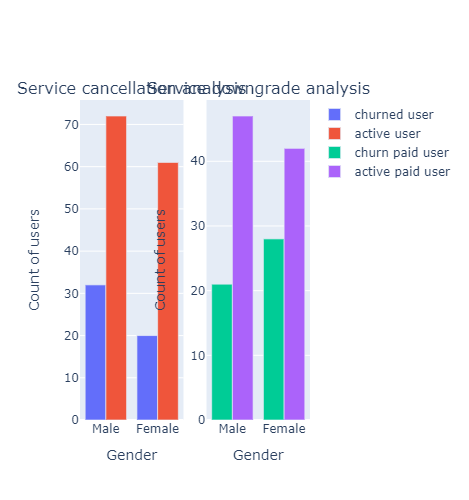

In [72]:
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=['Service cancellation analysis','Service downgrade analysis']
)

fig.append_trace(trace1,1,1)
fig.append_trace(trace2,1,1)
fig.append_trace(trace3,1,2)
fig.append_trace(trace4,1,2)

fig.layout.update(height=500, width=700, )
fig.update_xaxes(
    title_text = 'Gender'
)
fig.update_yaxes(
    title_text = 'Count of users'
)
fig.show()

- 위의 그래프로 보아서 성별의 영향이 큰지는 딱히 잘 모르겠지만 그래프를 통해서 
- 남성이 서비스에서 이탈할 확률이 근소하게 더 높은것 같고 
- 결제에서의 이탈 확률은 여성이 조금 더 높다는걸 확인할수 있다. 
- 하지만 유저 수가 225명으로 얼마 되지 않기 떄문에 큰 영향은 확신할수 없다

#### Impact of level (free vs paid)

In [73]:
level_no_churn = df_clean.select(['userId','level'])\
    .filter(F.col('row_number')==1)\
    .filter(filter_no_churn).distinct().toPandas()

level_churn_service= df_clean.select(['userId','level'])\
    .filter(F.col('row_number')==1)\
    .filter(filter_churn_service).distinct().toPandas()

In [74]:
trace1 = go.Bar(
    x=['Paid', 'Free'],
    y=[100*len(level_churn_service[level_churn_service['level']=='paid'])/level_churn_service.shape[0],
      100*len(level_churn_service[level_churn_service['level']=='free'])/level_churn_service.shape[0]],
    name='churned user'
)

trace2 = go.Bar(
    x=['Paid', 'Free'],
    y=[100* len(level_no_churn[level_no_churn['level']=='paid'])/level_no_churn.shape[0],
      100* len(level_no_churn[level_no_churn['level']=='free'])/level_no_churn.shape[0]],
    name='active user'
)


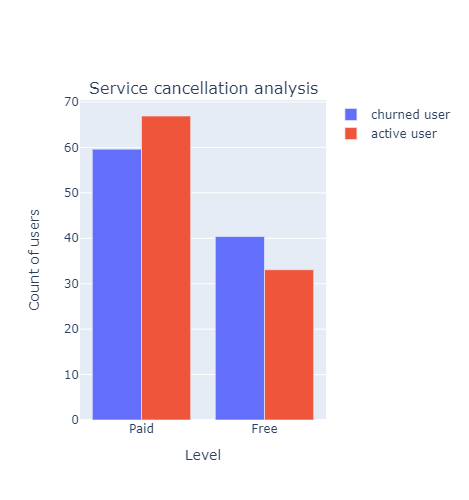

In [75]:
fig = make_subplots(
    rows=1, cols=1,
    subplot_titles=['Service cancellation analysis']
)

fig.append_trace(trace1,1,1)
fig.append_trace(trace2,1,1)


fig.layout.update(height=500, width=700, )
fig.update_xaxes(
    title_text = 'Level'
)
fig.update_yaxes(
    title_text = 'Count of users'
)
fig.show()

Level결과
- 위의 결과로 서비스 이탈 유저는 paid 의 비율이 높은걸 확인 가능 
- 하지만 현재 사용 유저중에서의 paid의 비율이 높은걸로도 확인가능 

#### Impact of the location of the user

In [76]:
df_clean.select(['location','state']).distinct().show()

+--------------------+-----+
|            location|state|
+--------------------+-----+
|Boston-Cambridge-...|MA-NH|
|Denver-Aurora-Lak...|   CO|
|           Flint, MI|   MI|
|Albany-Schenectad...|   NY|
|Deltona-Daytona B...|   FL|
|      Morgantown, WV|   WV|
|      Montgomery, AL|   AL|
|New Philadelphia-...|   OH|
|   Oklahoma City, OK|   OK|
|      Pittsburgh, PA|   PA|
|Manchester-Nashua...|   NH|
|Louisville/Jeffer...|KY-IN|
|           Selma, AL|   AL|
|Kingsport-Bristol...|TN-VA|
|    St. Louis, MO-IL|MO-IL|
|         Bozeman, MT|   MT|
|        Danville, VA|   VA|
|Sacramento--Rosev...|   CA|
|Miami-Fort Lauder...|   FL|
|         Raleigh, NC|   NC|
+--------------------+-----+
only showing top 20 rows



In [77]:
location_cols = ['userId','state']

location_no_churn = df_clean.select(['userId','state','level'])\
    .filter(filter_no_churn).distinct().toPandas()
location_churn_paid = df_clean.select(location_cols)\
    .filter(filter_churn_paid).distinct().toPandas()
location_churn_service = df_clean.select(location_cols)\
    .filter(filter_churn_service).distinct().toPandas()

In [78]:
locations = df_clean.select('state').distinct().toPandas()['state']

In [79]:
trace1 = go.Bar(
    x=locations,
    y=location_churn_service.groupby('state')['userId'].count(),
    name='churned user'
)

trace2 = go.Bar(
    x=locations,
    y=location_no_churn.groupby('state')['userId'].count(),
    name='active user'
)

trace3 = go.Bar(
    x=locations,
    y=location_churn_paid.groupby('state')['userId'].count(),
    name='churn paid user'
)
trace4 = go.Bar(
    x=locations,
    y=location_no_churn[location_no_churn['level']=='paid'].groupby('state')['userId'].count(),
    name='active paid user'
)


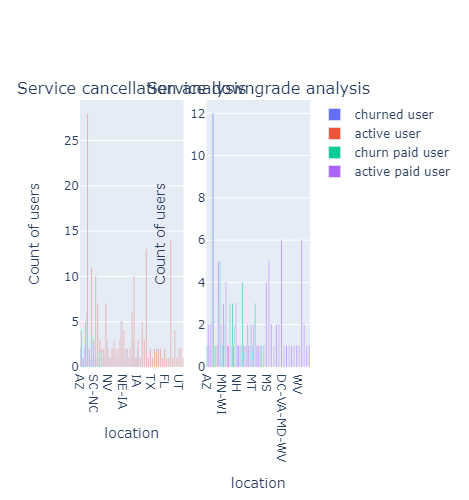

In [80]:
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=['Service cancellation analysis','Service downgrade analysis']
)

fig.append_trace(trace1,1,1)
fig.append_trace(trace2,1,1)
fig.append_trace(trace3,1,2)
fig.append_trace(trace4,1,2)

fig.layout.update(height=500, width=1000, )
fig.update_xaxes(
    title_text = 'location'
)
fig.update_yaxes(
    title_text = 'Count of users'
)
fig.show()

location 결과
- 특정 지역에서 서비스 이탈이 많은걸 확인 할수 있지만, 유저가 그리 많지 않아서 큰 의미는 잘 모르겠다.
- 하지만 유료결제 이탈에서의 LA 지역이 뚜렷하게 나타난다

#### Impact of avg number of repeat
- 같은노래의 반복 횟수를 분석해본다

In [81]:
df_clean.select(['userId']).distinct().count()

225

In [82]:
repeat_cols = ['userId','level','churn_service','churn_paid']

df_count_repeat = df_clean.groupby(repeat_cols)\
    .agg(F.count('song').alias('total_num_song'),\
        F.countDistinct('song').alias('unique_num_song'),\
        F.countDistinct('artist').alias('distinct_artist'))

In [83]:
df_count_repeat.orderBy('userId').show()

+------+-----+-------------+----------+--------------+---------------+---------------+
|userId|level|churn_service|churn_paid|total_num_song|unique_num_song|distinct_artist|
+------+-----+-------------+----------+--------------+---------------+---------------+
|    10| paid|            0|         0|           673|            629|            565|
|   100| paid|            0|         1|          2450|           2127|           1592|
|   100| free|            0|         1|           232|            220|            213|
|100001| free|            1|         0|           133|            129|            125|
|100002| paid|            0|         0|           195|            193|            184|
|100003| free|            1|         0|            51|             51|             50|
|100004| paid|            0|         2|           455|            435|            391|
|100004| free|            0|         2|           487|            470|            427|
|100005| free|            1|         0|    

In [84]:
# compute ratio of repeat song, distinct artist 

df_count_repeat = df_count_repeat\
    .withColumn('repeat_ratio',F.round(100-(100 * df_count_repeat['unique_num_song']/df_count_repeat['total_num_song'])))\
    .withColumn('repeat_distinct_artist', F.round(100*df_count_repeat['distinct_artist']/df_count_repeat['total_num_song']))

In [85]:
# segmentation
repeat_cols = ['userId','level','repeat_ratio','repeat_distinct_artist','distinct_artist']

count_repeat_no_churn = df_count_repeat.filter(filter_no_churn)\
    .select(repeat_cols).distinct().dropna().toPandas()

count_repeat_churn_paid = df_count_repeat.filter(filter_churn_paid)\
    .select(repeat_cols).distinct().dropna().toPandas()
count_repeat_churn_service = df_count_repeat.filter(filter_churn_service)\
    .select(repeat_cols).distinct().dropna().toPandas()

In [86]:
# active user ratio
count_repeat_no_churn.repeat_ratio.mean(),count_repeat_no_churn.repeat_distinct_artist.mean()

(4.101522842639594, 87.22842639593908)

In [87]:
# churn_service ratio
count_repeat_churn_service.repeat_ratio.mean(), count_repeat_churn_service.repeat_distinct_artist.mean()

(3.3780487804878048, 88.97560975609755)

In [88]:
# churn paid
count_repeat_churn_paid.repeat_ratio.mean(),count_repeat_churn_paid.repeat_distinct_artist.mean(),

(5.63265306122449, 82.91836734693878)

In [89]:
# active paid user 
count_repeat_active_paid = count_repeat_no_churn[count_repeat_no_churn['level']=='paid']

count_repeat_active_paid.repeat_ratio.mean(), count_repeat_active_paid.repeat_distinct_artist.mean()

(7.056818181818182, 78.68181818181819)

##### visualization : number of repeat

In [90]:
trace1 = go.Bar(
    x=['repeat','distinct_artist'],
    y=[# churn_service ratio
count_repeat_churn_service.repeat_ratio.mean(), count_repeat_churn_service.repeat_distinct_artist.mean()],
    name='churned user'
)

trace2 = go.Bar(
    x=['repeat','distinct_artist'],
    y=[count_repeat_no_churn.repeat_ratio.mean(),count_repeat_no_churn.repeat_distinct_artist.mean()],
    name='active user'
)

trace3 = go.Bar(
    x=['repeat','distinct_artist'],
    y=[count_repeat_churn_paid.repeat_ratio.mean(),count_repeat_churn_paid.repeat_distinct_artist.mean()],
    name='churn paid user'
)
trace4 = go.Bar(
    x=['repeat','distinct_artist'],
    y=[count_repeat_active_paid.repeat_ratio.mean(), count_repeat_active_paid.repeat_distinct_artist.mean()],
    name='active paid user'
)


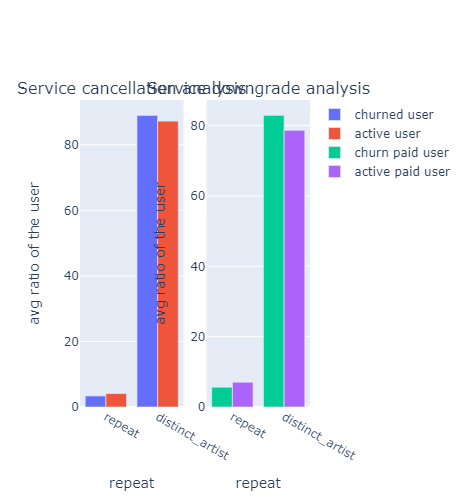

In [91]:
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=['Service cancellation analysis','Service downgrade analysis']
)

fig.append_trace(trace1,1,1)
fig.append_trace(trace2,1,1)
fig.append_trace(trace3,1,2)
fig.append_trace(trace4,1,2)

fig.layout.update(height=500, width=700, )
fig.update_xaxes(
    title_text = 'repeat'
)
fig.update_yaxes(
    title_text = 'avg ratio of the user'
)
fig.show()

number of repeat 결과
- 서비스나 유료결제에서의 이탈 유저의 평균 같은 노래 반복 비율은 상대적으로, 새로운 노래를 듣는 비율보다 낮으며 활성화된 이용 유저들보다 낮다.
- 같은 노래를 듣는 반복 비율이 낮으면 => 서비스, 유료결제에서의 이탈에 영향을 준다고 볼 수 있다

### Impact of the avg number of ads
- 평균 광고 시청 회수 분석을 통해 이탈율에게 영향을 주는지 확인

In [92]:
is_ads = udf(lambda x: 1 if x == 'Roll Advert' else 0 , IntegerType())
is_song = udf(lambda x:1 if x == 'NextSong' else 0, IntegerType())

# apply udf to on page column 

df_count_ads = df_clean.withColumn('is_song', is_song(F.col('page')))\
    .withColumn('is_ads', is_ads(F.col('page')))


In [93]:
df_count_ads = df_count_ads.groupby(['userId','level','churn_service','churn_paid'])\
    .agg(F.sum('is_song').alias('num_song'),\
        F.sum('is_ads').alias('num_ads'))

In [94]:
df_count_ads = df_count_ads.withColumn('ratio_song_ads',F.round(100*df_count_ads['num_ads']/df_count_ads['num_song'],2))

In [95]:
# 422 count
df_count_ads.show()

+------+-----+-------------+----------+--------+-------+--------------+
|userId|level|churn_service|churn_paid|num_song|num_ads|ratio_song_ads|
+------+-----+-------------+----------+--------+-------+--------------+
|    24| free|            0|         1|     386|     30|          7.77|
|300024| paid|            0|         0|      88|      0|           0.0|
|100004| paid|            0|         2|     455|      7|          1.54|
|100015| free|            1|         1|     474|     66|         13.92|
|300004| paid|            0|         1|     123|      0|           0.0|
|    98| paid|            0|         0|    2033|      1|          0.05|
|    57| free|            0|         0|      92|      6|          6.52|
|    99| paid|            0|         0|     399|      1|          0.25|
|    92| free|            0|         1|     850|     82|          9.65|
|200001| free|            1|         0|     115|      3|          2.61|
|300007| paid|            1|         0|     111|      2|        

In [96]:
ads_cols = ['userId','ratio_song_ads','level']

count_ads_no_churn = df_count_ads.filter(filter_no_churn)\
    .select(ads_cols).distinct().toPandas()
count_ads_churn_paid = df_count_ads.filter(filter_churn_paid)\
    .select(ads_cols).distinct().toPandas()
count_ads_churn_service = df_count_ads.filter(filter_churn_service)\
    .select(ads_cols).distinct().toPandas()

In [97]:
# 1.churn_service_paid vs active_paid
# churn_Service_paid_user
trace1 = go.Box(
    x=count_ads_churn_service[count_ads_churn_service['level']=='paid']['ratio_song_ads'],
    name='churned service paid user'
)
# active paid user
trace2 = go.Box(
    x=count_ads_no_churn[count_ads_no_churn['level']=='paid']['ratio_song_ads'],
    name='active paid user'
)

# 2. churn_Service free user vs active free user
# churn_service_free_user
trace3 = go.Box(
    x=count_ads_churn_service[count_ads_churn_service['level']=='free']['ratio_song_ads'],
    name='churn service free user'
)
trace4 = go.Box(
    x=count_ads_no_churn[count_ads_no_churn['level']=='free']['ratio_song_ads'],
    name='active free user'
)

### 3. downgrade: churn_paid user vs active paid user

trace5 = go.Box(
    x=count_ads_churn_paid[count_ads_churn_paid['level']=='paid']['ratio_song_ads'],
    name='churn paid user'
)
trace6 = go.Box(
    x=count_ads_no_churn[count_ads_no_churn['level']=='paid']['ratio_song_ads'],
    name='active paid user'
)

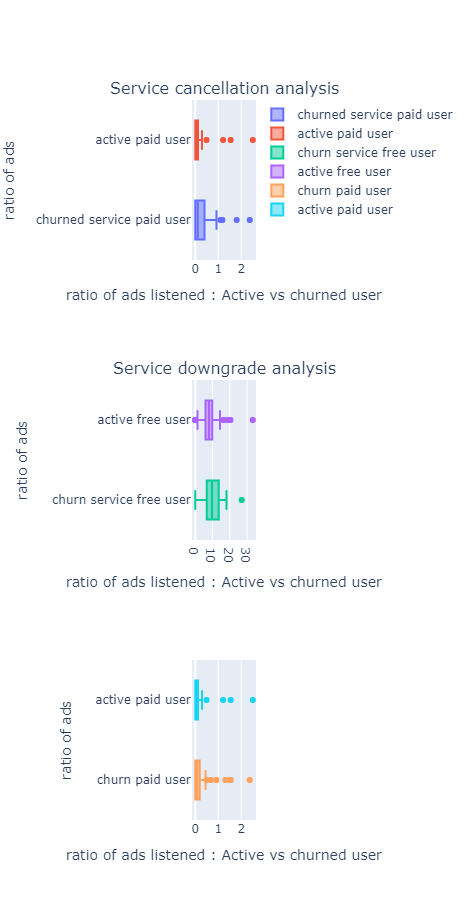

In [98]:
fig = make_subplots(
    rows=3, cols=1,
    subplot_titles=['Service cancellation analysis','Service downgrade analysis']
)

fig.append_trace(trace1,1,1)
fig.append_trace(trace2,1,1)
fig.append_trace(trace3,2,1)
fig.append_trace(trace4,2,1)
fig.append_trace(trace5,3,1)
fig.append_trace(trace6,3,1)


fig.layout.update(height=900, width=700, )
fig.update_xaxes(
    title_text = 'ratio of ads listened : Active vs churned user'
)
fig.update_yaxes(
    title_text = 'ratio of ads'
)
fig.show()

광고 횟수 분석 결과
- 전체적으로 서비스나 유료 멤버쉽에서의 이탈한 유저들은 상대적으로 노래 대비 광고 시청 비율이 높았다.
- free 유저가 paid 유저보다 평균적으로 약 10배정도 광고를 더 시청한다
- 광고 시청 횟수 비율이 이탈율에 영향을 주는것 같다

#### Impact of the number of logins 

##### count login

In [99]:
# login count df
df_count_login = df_clean.groupby(['userId','level','churn_service','churn_paid'])\
    .agg(F.countDistinct('sessionId').alias('count_login'))

In [100]:
# checking 
df_count_login.toPandas()

userId level  churn_service  churn_paid  count_login
0        10  paid              0           0            6
1       100  paid              0           1           29
2       100  free              0           1            8
3    100001  free              1           0            4
4    100002  paid              0           0            4
..      ...   ...            ...         ...          ...
355      97  paid              0           0           17
356      98  free              0           0           14
357      98  paid              0           0           15
358      99  free              0           0            5
359      99  paid              0           0            7

[360 rows x 5 columns]

In [101]:
login_cols = ['userId','count_login','level']

login_no_churn = df_count_login.filter(filter_no_churn)\
    .select(login_cols).toPandas()
login_churn_paid = df_count_login.filter(filter_churn_paid)\
    .select(login_cols).toPandas()
login_churn_service = df_count_login.filter(filter_churn_service)\
    .select(login_cols).toPandas()

In [102]:
print("active user",login_no_churn.count_login.mean())
print("churn service user", login_churn_service.count_login.mean())
print("active paid user",login_no_churn[login_no_churn['level']=='paid'].count_login.mean())
print("churn paid user",login_churn_paid.count_login.mean())

active user 7.924242424242424
churn service user 7.036585365853658
active paid user 10.752808988764045
churn paid user 14.275510204081632


In [103]:
# 1.churn_service_paid vs active_paid
# churn_Service_paid_user
trace1 = go.Box(
    x=login_churn_service[login_churn_service['level']=='paid']['count_login'],
    name='churned service paid user'
)
# active paid user
trace2 = go.Box(
    x=login_no_churn[login_no_churn['level']=='paid']['count_login'],
    name='active paid user'
)

# 2. churn_Service free user vs active free user
# churn_service_free_user
trace3 = go.Box(
    x=login_churn_service[login_churn_service['level']=='free']['count_login'],
    name='churn service free user'
)
trace4 = go.Box(
    x=login_no_churn[login_no_churn['level']=='free']['count_login'],
    name='active free user'
)

### 3. downgrade: churn_paid user vs active paid user

trace5 = go.Box(
    x=login_churn_paid[login_churn_paid['level']=='paid']['count_login'],
    name='churn paid user'
)
trace6 = go.Box(
    x=login_no_churn[login_no_churn['level']=='paid']['count_login'],
    name='active paid user'
)

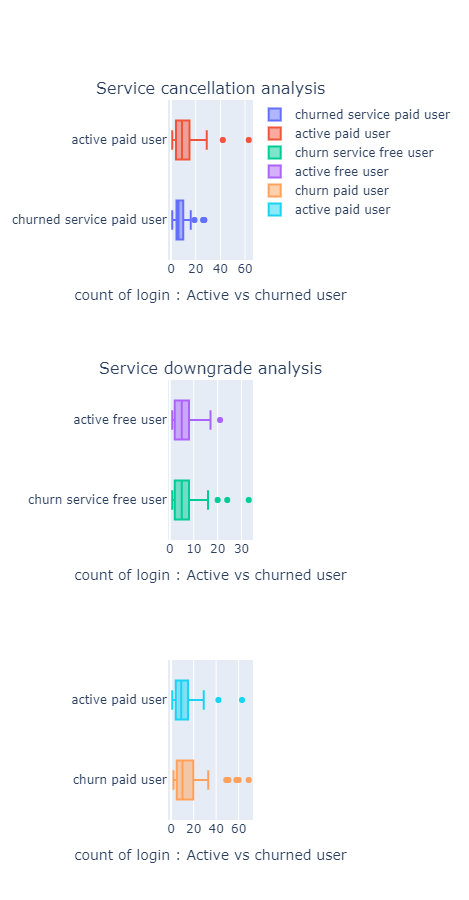

In [104]:
fig = make_subplots(
    rows=3, cols=1,
    subplot_titles=['Service cancellation analysis','Service downgrade analysis']
)

fig.append_trace(trace1,1,1)
fig.append_trace(trace2,1,1)
fig.append_trace(trace3,2,1)
fig.append_trace(trace4,2,1)
fig.append_trace(trace5,3,1)
fig.append_trace(trace6,3,1)


fig.layout.update(height=900, width=700, )
fig.update_xaxes(
    title_text = 'count of login : Active vs churned user'
)
# fig.update_yaxes(
#     title_text = ''
# )
fig.show()

#### avg time between two login(delta time)
- 세션 사이의 평균 시간차

In [105]:
recent_user_level = df_clean.filter(F.col('row_number')==1)\
    .select(['userId','level']).distinct()

In [106]:
# grouping by userd and sorting by descending date
windowval = Window.partitionBy('userId').orderBy(F.desc('ts'))

# add next_date column 
df_delta_login = df_clean.withColumn('next_date',lag('date',1).over(windowval))

# calculate the delta between two login 
df_delta_login = df_delta_login.withColumn("delta_time", F.datediff(F.col('next_date'),F.col('date')))


In [107]:
# compute the avg delta_time between login for each user 

delta_cols = ['userId','level','churn_service','churn_paid','delta_time']

df_delta_login = df_delta_login.select(delta_cols)\
    .filter(df_delta_login['delta_time'] != 0)
distinct_session = df_clean.groupby('userId').agg(F.countDistinct('sessionId').alias('user_num_session'))

# join: df_delta_login + distinct_session
df_delta_login = df_delta_login.join(distinct_session, on=['userId'], how='inner')

# calculate avg delta time , total_avg_delta
df_delta_login = df_delta_login.withColumn('avg_delta',F.col('delta_time')/F.col('user_num_session'))\
    .withColumn('total_avg_delta',F.sum('avg_delta').over(Window.partitionBy('userId')))


In [108]:
delta_login = df_delta_login.groupby(['userId','level','churn_service','churn_paid'])\
    .agg(F.max('total_avg_delta').alias('total_avg_delta'))

In [109]:
# function 
def set_recent_user_level(df):
    """
        Distinct only recent userId, level 
        
        Input:
            df(spark dataframe)
    """
    recent_user_level = df_clean.filter(F.col('row_number')==1)\
    .select(['userId','level']).distinct()
    
    df_result =  recent_user_level.join(df, on=['userId','level'], how='inner')
    
    return df_result

In [110]:
res_delta_login = set_recent_user_level(delta_login)

In [111]:
delta_login_no_churn = res_delta_login.filter(filter_no_churn).toPandas()
delta_login_churn_paid = res_delta_login.filter(filter_churn_paid).toPandas()
delta_login_churn_service = res_delta_login.filter(filter_churn_service).toPandas()

In [112]:
res_delta_login.toPandas().head()

userId level  churn_service  churn_paid  total_avg_delta
0     100  paid              0           1         1.657143
1  100004  paid              0           2         2.714286
2  100005  free              1           0         3.600000
3  100006  free              1           0         1.000000
4  100007  paid              1           0         6.444444

In [113]:
# avg 
print("churned service user avg delta time of login:",delta_login_churn_service.total_avg_delta.mean())
print("churned paid user avg delta time of login:",delta_login_churn_paid.total_avg_delta.mean())
print("no churned user avg delta time of login:",delta_login_no_churn.total_avg_delta.mean())

churned service user avg delta time of login: 2.662323724785025
churned paid user avg delta time of login: 3.0380143552030763
no churned user avg delta time of login: 5.4701865047104885


In [114]:
# 1.churn_service vs active
# churn service
trace1 = go.Box(
    x=delta_login_churn_service['total_avg_delta'],
    name='churned service user'
)
# active user
trace2 = go.Box(
    x=delta_login_no_churn['total_avg_delta'],
    name='active user'
)

# 2. churn paid: churn_paid vs active paid
# churn_service_free_user
trace3 = go.Box(
    x=delta_login_churn_paid['total_avg_delta'],
    name='churn paid ser'
)
trace4 = go.Box(
    x=delta_login_no_churn[delta_login_no_churn['level']=='paid']['total_avg_delta'],
    name='active paid user'
)

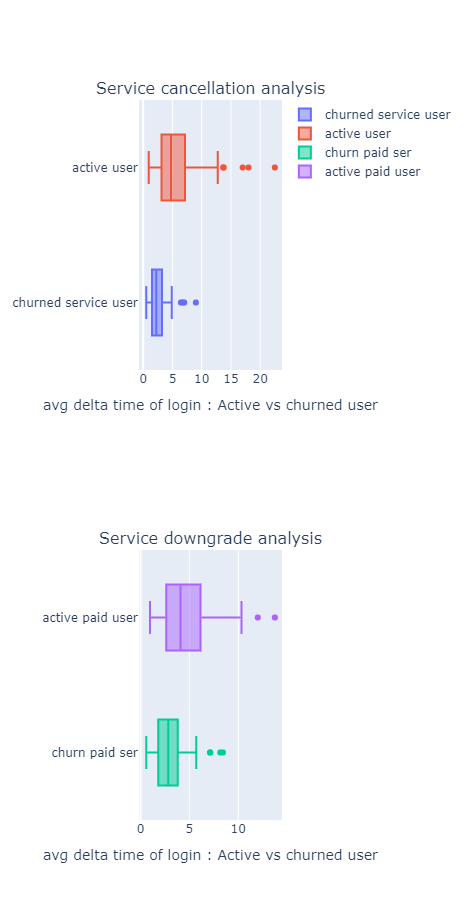

In [115]:
fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=['Service cancellation analysis','Service downgrade analysis']
)

fig.append_trace(trace1,1,1)
fig.append_trace(trace2,1,1)
fig.append_trace(trace3,2,1)
fig.append_trace(trace4,2,1)

fig.layout.update(height=900, width=700, )
fig.update_xaxes(
    title_text = 'avg delta time of login : Active vs churned user'
)
# fig.update_yaxes(
#     title_text = ''
# )
fig.show()

avg delta time of login 결과 
- 서비스, 유료멤버쉽에서 이탈한 유저들의 평균 로그인 하는 간격의 시간차가 더 평균적으로 더 짧은것을 확인 할 수 있다. 자주 로그인 하는 유저들이 이탈한다는것을 확인 가능.

### Impact of daily behavior
- page에 해당하는 다른 여러 액션이 이탈율에 영향을 주는지 분석해본다 
- 노래를 듣는지, thumb up 같은 요소 분석
- 주간 단위로 나눠서 분석한다

In [116]:
# udf=> is_song, is_thumb_up, is_thumb_down 
is_song = udf(lambda x: 1 if x == 'NextSong' else 0 , IntegerType())
is_thumb_up = udf(lambda x:1 if x =='Thumbs Up' else 0, IntegerType())
is_thumb_down  = udf(lambda x:1 if x== 'Thumbs Down' else 0, IntegerType())

# add column using udf 
# daily_action
df_daily_action = df_clean.withColumn('is_song',is_song(F.col('page')))\
    .withColumn('is_thumb_up',is_thumb_up(F.col('page')))\
    .withColumn('is_thumb_down',is_thumb_down(F.col('page')))\
    .withColumn('weekofyear',F.weekofyear(F.col('date')))

In [117]:
# create window per week 
windowval = Window.partitionBy(['userId','year','weekofyear']).orderBy('ts')\
    .rangeBetween(Window.unboundedPreceding,0)

# compute total_num_song_week, thumb_up_week
df_daily_action = df_daily_action.withColumn('total_song_week',F.sum('is_song').over(windowval))\
    .withColumn('total_thumb_up_week',F.sum('is_thumb_up').over(windowval))\
    .withColumn('total_thumb_down_week', F.sum('is_thumb_down').over(windowval))


In [118]:
# groupby 

daily_cols = ['userId','year','weekofyear','level','churn_service','churn_paid']

df_daily_filt = df_daily_action.groupby(daily_cols)\
    .agg(F.max('total_song_week').alias('max_song_week'), \
        F.max('total_thumb_up_week').alias('max_thumb_up_week'),\
        F.max('total_thumb_down_week').alias('max_thumb_down_week'))

# calculate avg 
df_daily_filt = df_daily_filt.withColumn('avg_song_week',F.col('max_song_week')/7)\
    .withColumn('avg_thumb_up_week',F.col('max_thumb_up_week')/7)\
    .withColumn('avg_thumb_down_week',F.col('max_thumb_down_week')/7)

In [119]:
# apply segmentation 
avg_week_no_churn = df_daily_filt.filter(filter_no_churn).distinct().toPandas()
avg_week_churn_paid = df_daily_filt.filter(filter_churn_paid).distinct().toPandas()
avg_week_churn_service = df_daily_filt.filter(filter_churn_service).distinct().toPandas()

In [120]:
avg_week_no_churn.columns

Index(['userId', 'year', 'weekofyear', 'level', 'churn_service', 'churn_paid',
       'max_song_week', 'max_thumb_up_week', 'max_thumb_down_week',
       'avg_song_week', 'avg_thumb_up_week', 'avg_thumb_down_week'],
      dtype='object')

###### avg_num_song_week

In [121]:
# 1.churn_service vs active
# churn service
trace1 = go.Box(
    x=avg_week_churn_service['avg_song_week'].unique(),
    name='churned service user'
)
# active user
trace2 = go.Box(
    x=avg_week_no_churn['avg_song_week'].unique(),
    name='active user'
)

# 2. churn paid: churn_paid vs active paid
# churn_service_free_user
trace3 = go.Box(
    x=avg_week_churn_paid['avg_song_week'].unique(),
    name='churn paid ser'
)
trace4 = go.Box(
    x=avg_week_no_churn[avg_week_no_churn['level']=='paid']['avg_song_week'].unique(),
    name='active paid user'
)

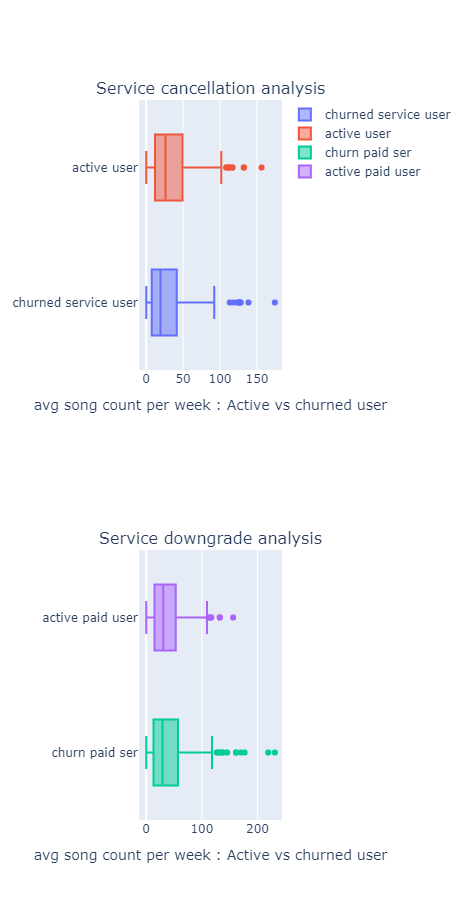

In [122]:
fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=['Service cancellation analysis','Service downgrade analysis']
)

fig.append_trace(trace1,1,1)
fig.append_trace(trace2,1,1)
fig.append_trace(trace3,2,1)
fig.append_trace(trace4,2,1)

fig.layout.update(height=900, width=700, )
fig.update_xaxes(
    title_text = 'avg song count per week : Active vs churned user'
)
# fig.update_yaxes(
#     title_text = ''
# )
fig.show()

avg_song_count per week 결과 
- 서비스에서 이탈한 유저가 상대적으로 주간 평균 노래 듣는 횟수가 활성화된 유저보다 적은 편이다.
- 유료멤버쉽 에서 이탈한 유저가 상대적으로 활성화된 유료 유저보다 주간 평균 노래 듣ㄷ는 회수가 근소하게 많다.

###### avg_thump_up_week

In [123]:
# 1.churn_service vs active
# churn service
trace1 = go.Box(
    x=avg_week_churn_service['avg_thumb_up_week'].unique(),
    name='churned service user'
)
# active user
trace2 = go.Box(
    x=avg_week_no_churn['avg_thumb_up_week'].unique(),
    name='active user'
)

# 2. churn paid: churn_paid vs active paid
# churn_service_free_user
trace3 = go.Box(
    x=avg_week_churn_paid['avg_thumb_up_week'].unique(),
    name='churn paid ser'
)
trace4 = go.Box(
    x=avg_week_no_churn[avg_week_no_churn['level']=='paid']['avg_thumb_up_week'].unique(),
    name='active paid user'
)

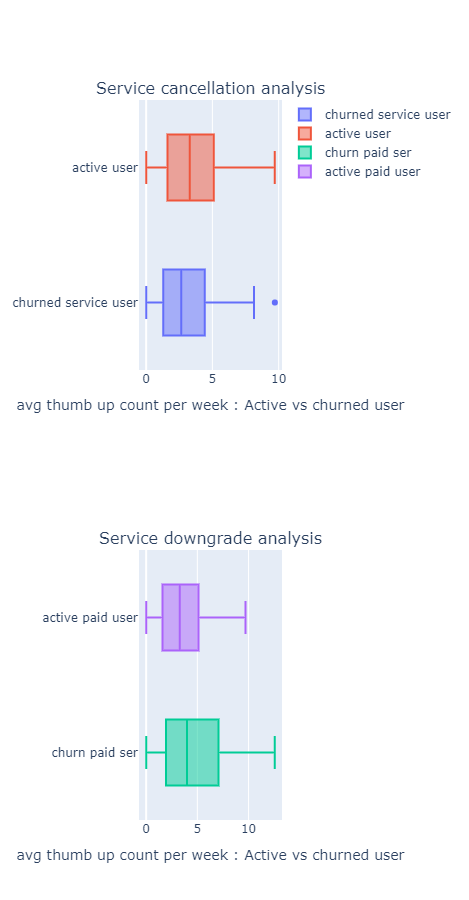

In [124]:
fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=['Service cancellation analysis','Service downgrade analysis']
)

fig.append_trace(trace1,1,1)
fig.append_trace(trace2,1,1)
fig.append_trace(trace3,2,1)
fig.append_trace(trace4,2,1)

fig.layout.update(height=900, width=700, )
fig.update_xaxes(
    title_text = 'avg thumb up count per week : Active vs churned user'
)
# fig.update_yaxes(
#     title_text = ''
# )
fig.show()

avg thumb up week 결과
- 서비스 이탈 유저가 평균적으로 따봉주는 횟수가 적다 
- 유료 멤버쉽 이탈 유저가 평균적으로 따봉주는 횟수가 많다 

- 결과적으로 서비스 이탈 유저는 노래를 듣거나, 따봉을 주거나 하는 daily action 에서의 빈도가 낮고, 유료 멤버쉽 이탈 유저는 daily action 에서의 빈도가 잦다

#### Impact of the listening time per session
- 세션마다 노래를 듣는 시간을 분석해보자

In [165]:
# window parititon by userId and sorting by descending timestamp
window_user_ts = Window.partitionBy('userId').orderBy(desc('ts'))

# session window 
window_session = Window.partitionBy(['userId','sessionId']).orderBy('ts')\
    .rangeBetween(Window.unboundedPreceding,0)

# new column next_ts, next_action

df_listen_session = df_clean.withColumn('next_ts',lag('ts',1).over(window_user_ts))\
    .withColumn('next_action',lag('page',1).over(window_user_ts))\
    .filter(F.col('page')=='NextSong')

# calculate the difference between two timestamp
df_listen_session = df_listen_session.withColumn('diff_ts',(F.col('next_ts')-F.col('ts'))/1000)

# add column with total listening per session 
# 세션별로 노래 들은 시간 ts => list_session
df_listen_session = df_listen_session.withColumn('listen_session',F.sum('diff_ts').over(window_session))

# 즉 list_Session의 총합 max로 해서 
# 그룹으로 묶어버리기 

df_listen_session_filt = df_listen_session.groupby(['userId','sessionId','level','churn_service','churn_paid'])\
    .agg(F.max('listen_session').alias('total_listen_session'),\
        F.max('iteminSession').alias('item_session'))

# avg listen time session 
df_listen_session_filt = df_listen_session_filt.withColumn('avg_listen_session',
                                                        F.round(F.col('total_listen_session')/F.col('item_session')))

In [166]:
# segmentation 

listen_session_no_churn = df_listen_session_filt.filter(filter_no_churn).toPandas()
listen_session_churn_paid= df_listen_session_filt.filter(filter_churn_paid).toPandas()
listen_session_churn_service = df_listen_session_filt.filter(filter_churn_service).toPandas()

In [167]:
listen_session_no_churn.head()

userId  sessionId level  churn_service  churn_paid  total_listen_session  \
0  100010         31  free              0           0                5147.0   
1  100010         78  free              0           0                1149.0   
2  100010        113  free              0           0                5783.0   
3  100010        118  free              0           0                7816.0   
4  100010        133  free              0           0                8609.0   

   item_session  avg_listen_session  
0            38               135.0  
1             7               164.0  
2            56               103.0  
3            56               140.0  
4            72               120.0

In [168]:
# 1.churn_service vs active
# churn service
trace1 = go.Box(
    x=listen_session_churn_service['avg_listen_session'].unique(),
    name='churned service user'
)
# active user
trace2 = go.Box(
    x=listen_session_no_churn['avg_listen_session'].unique(),
    name='active user'
)

# 2. churn paid: churn_paid vs active paid
# churn_service_free_user
trace3 = go.Box(
    x=listen_session_churn_paid['avg_listen_session'].unique(),
    name='churn paid ser'
)
trace4 = go.Box(
    x=listen_session_no_churn[listen_session_no_churn['level']=='paid']['avg_listen_session'].unique(),
    name='active paid user'
)

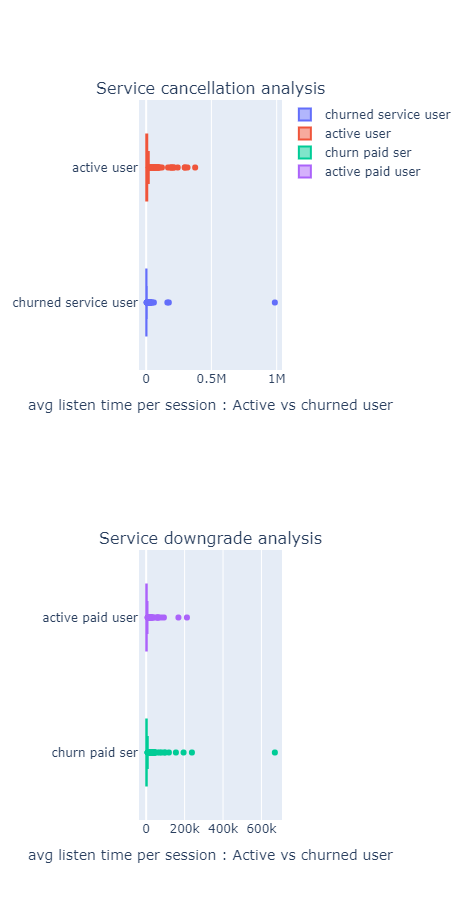

In [169]:
fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=['Service cancellation analysis','Service downgrade analysis']
)

fig.append_trace(trace1,1,1)
fig.append_trace(trace2,1,1)
fig.append_trace(trace3,2,1)
fig.append_trace(trace4,2,1)

fig.layout.update(height=900, width=1200, )
fig.update_xaxes(
    title_text = 'avg listen time per session : Active vs churned user'
)
# fig.update_yaxes(
#     title_text = ''
# )
fig.show()

In [172]:
trace1 = go.Bar(
    x=['avg_listen_time','avg_item_in_session'],
    y=[listen_session_churn_service.avg_listen_session.mean(),listen_session_churn_service.item_session.mean()],
    name='churn service user'
)

trace2 = go.Bar(
    x=['avg_listen_time','avg_item_in_session'],
    y=[listen_session_no_churn.avg_listen_session.mean(),listen_session_no_churn.item_session.mean()],
    name='active user'
)

trace3 = go.Bar(
    x=['avg_listen_time','avg_item_in_session'],
    y=[listen_session_churn_paid.avg_listen_session.mean(),listen_session_churn_paid.item_session.mean()],
    name='churn paid user'
)
trace4 = go.Bar(
    x=['avg_listen_time','avg_item_in_session'],
    y=[listen_session_no_churn[listen_session_no_churn['level']=='paid'].avg_listen_session.mean(),
      listen_session_no_churn[listen_session_no_churn['level']=='paid'].item_session.mean()],
    name='active paid user'
)


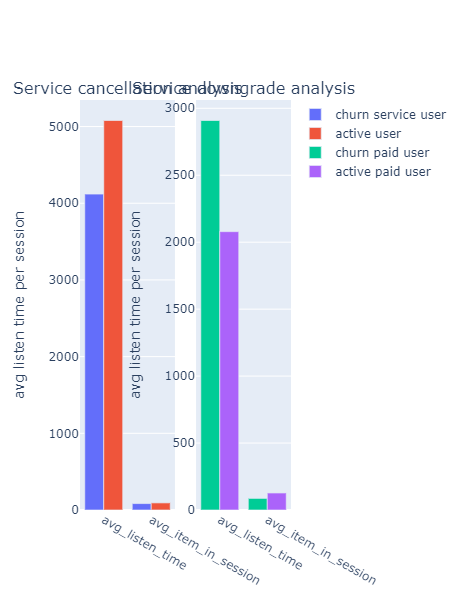

In [173]:
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=['Service cancellation analysis','Service downgrade analysis']
)

fig.append_trace(trace1,1,1)
fig.append_trace(trace2,1,1)
fig.append_trace(trace3,1,2)
fig.append_trace(trace4,1,2)

fig.layout.update(height=600, width=900, )
# fig.update_xaxes(
#     title_text = 'avg listen time'
# )
fig.update_yaxes(
    title_text = 'avg listen time per session'
)
fig.show()

avg_listen_time per session+ avg_number_item per session 결과
- 서비스 이탈 유저보다 현재 활성화 되어 있는 유저가 세션마다 듣는 시간이 평균적으로 높다 
- 서비스 이탈 유저보다 활성화 유저의 세션별 아이템 수가 평균적으로 높다
- 유료 멤버쉽 이탈 유저의 평균 세션별 듣는 시간이 현재 유료 활성화 유저보다 높다 
- 유료 멤버쉽 이탈 유저의 평균 세션별 아이템 수가 현재 유료 활성화 유저보다 낮으므로, 
    유료 멤버쉽 이탈 유저는 아무튼 세션별 평균적으로 노래를 오래 듣는다고 파악할수 있다.

#### Impact of the time of the activity (count of actions)


- 각 유저의 행동 횟수를 page 컬럼을 통해 구해본다

###### avg_action_per_day

In [126]:
# get the total number of actions per user 
df_action_user = df_clean.groupby(['userId','level','churn_service','churn_paid'])\
    .agg(F.count('page').alias('action_per_user')).toPandas()

In [127]:
# count number of actions per day 
df_action_user_day = df_clean.groupby(['userId','year','month','day'])\
    .agg(F.count('page').alias('action_per_day')).toPandas()

In [128]:
avg_action_day = pd.merge(df_action_user, df_action_user_day,on='userId')

In [129]:
avg_action_day['avg_action_per_day'] = avg_action_day['action_per_day']/avg_action_day['action_per_user']

In [130]:
avg_action_day.head()

userId level  churn_service  churn_paid  action_per_user  year  month  day  \
0     10  paid              0           0              795  2018     10    8   
1     10  paid              0           0              795  2018     10   19   
2     10  paid              0           0              795  2018     10   18   
3     10  paid              0           0              795  2018     10   30   
4     10  paid              0           0              795  2018     11    3   

   action_per_day  avg_action_per_day  
0              70            0.088050  
1             259            0.325786  
2             190            0.238994  
3              25            0.031447  
4               8            0.010063

In [131]:
# set segmentation 

where_churn_paid = (avg_action_day['churn_paid']!=0)
where_churn_service = (avg_action_day['churn_service']!=0)
where_no_churn = (~where_churn_paid)&(~where_churn_service)

action_day_no_churn = avg_action_day[(avg_action_day['churn_service']==0)&(avg_action_day['churn_paid']==0)]
action_day_churn_paid = avg_action_day[(avg_action_day['churn_paid']!=0)&(avg_action_day['churn_service']==0)]
action_day_churn_service = avg_action_day[avg_action_day['churn_service']!=0]


NameError: name 'where_churn_paid' is not defined

In [ ]:
# data quality count check 
assert avg_action_day.shape[0] == (action_day_no_churn.shape[0]+action_day_churn_paid.shape[0]+action_day_churn_service.shape[0])

In [ ]:
# box plot unique 
# 1.churn_service vs active
# churn service
trace1 = go.Box(
    x=action_day_churn_service['avg_action_per_day'].unique(),
    name='churned service user'
)
# active user
trace2 = go.Box(
    x=action_day_no_churn['avg_action_per_day'].unique(),
    name='active user'
)

# 2. churn paid: churn_paid vs active paid
# churn_service_free_user
trace3 = go.Box(
    x=action_day_churn_paid['avg_action_per_day'].unique(),
    name='churn paid ser'
)
trace4 = go.Box(
    x=action_day_no_churn[action_day_no_churn['level']=='paid']['avg_action_per_day'].unique(),
    name='active paid user'
)

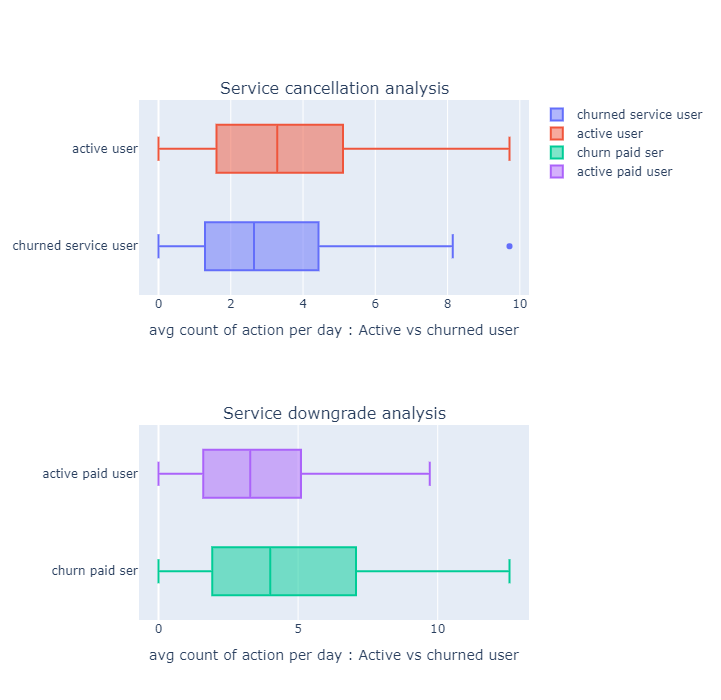

In [132]:
fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=['Service cancellation analysis','Service downgrade analysis']
)

fig.append_trace(trace1,1,1)
fig.append_trace(trace2,1,1)
fig.append_trace(trace3,2,1)
fig.append_trace(trace4,2,1)

fig.layout.update(height=700, width=700, )
fig.update_xaxes(
    title_text = 'avg count of action per day : Active vs churned user'
)
# fig.update_yaxes(
#     title_text = ''
# )
fig.show()

##### avg_action per week, weekend

In [133]:
df_action_user

userId level  churn_service  churn_paid  action_per_user
0        10  paid              0           0              795
1       100  paid              0           1             2914
2       100  free              0           1              300
3    100001  free              1           0              187
4    100002  paid              0           0              218
..      ...   ...            ...         ...              ...
355      97  paid              0           0             1940
356      98  free              0           0              483
357      98  paid              0           0             2408
358      99  free              0           0              140
359      99  paid              0           0              474

[360 rows x 5 columns]

In [134]:
is_weekday = udf(lambda x:1 if x in [1,2,3,4,5] else 0, IntegerType())

In [135]:
df_week_action = df_clean.withColumn('is_weekday',is_weekday('dayofweek'))

In [136]:
df_week_action_weekday = df_week_action.filter(F.col('is_weekday')==1)\
    .groupby(['userId','level'])\
    .agg(F.count('page').alias('count_action_weekday'))
df_week_action_weekend = df_week_action.filter(F.col('is_weekday')!=1)\
    .groupby(['userId','level'])\
    .agg(F.count('page').alias('count_action_weekend'))

In [137]:
count_week_action=df_week_action.groupby(['userId','level','churn_service','churn_paid','is_weekday'])\
    .agg(F.count('page').alias('count_action_week'))

In [138]:
# set segmentation 
filter_weekday = F.col('is_weekday') == 1
filter_weekend = ~(filter_weekday)
# where_weekday = 
count_action_weekday = count_week_action.filter(filter_weekday)
count_action_weekend = count_week_action.filter(filter_weekend)


action_weekday_no_churn = count_action_weekday.filter(filter_no_churn).toPandas()
action_weekday_churn_paid = count_action_weekday.filter(filter_churn_paid).toPandas()
action_weekday_churn_service = count_action_weekday.filter(filter_churn_service).toPandas()

action_weekend_no_churn = count_action_weekend.filter(filter_no_churn).toPandas()
action_weekend_churn_paid = count_action_weekend.filter(filter_churn_paid).toPandas()
action_weekend_churn_service = count_action_weekend.filter(filter_churn_service).toPandas()


In [139]:
trace1 = go.Bar(
    x=['weekday','weekend'],
    y=[action_weekday_churn_service.count_action_week.mean(),
       action_weekend_churn_service.count_action_week.mean()],
    name='churn service user'
)

trace2 = go.Bar(
    x=['weekday','weekend'],
    y=[action_weekday_no_churn.count_action_week.mean(),
       action_weekend_no_churn.count_action_week.mean()],
    name='active user'
)

trace3 = go.Bar(
    x=['weekday','weekend'],
    y=[action_weekday_churn_paid.count_action_week.mean(),
       action_weekend_churn_paid.count_action_week.mean()],
    name='churn paid user'
)
trace4 = go.Bar(
    x=['weekday','weekend'],
    y=[action_weekday_no_churn[action_weekday_no_churn['level']=='paid'].count_action_week.mean(),
      action_weekend_no_churn[action_weekend_no_churn['level']=='paid'].count_action_week.mean()],
    name='active paid user'
)


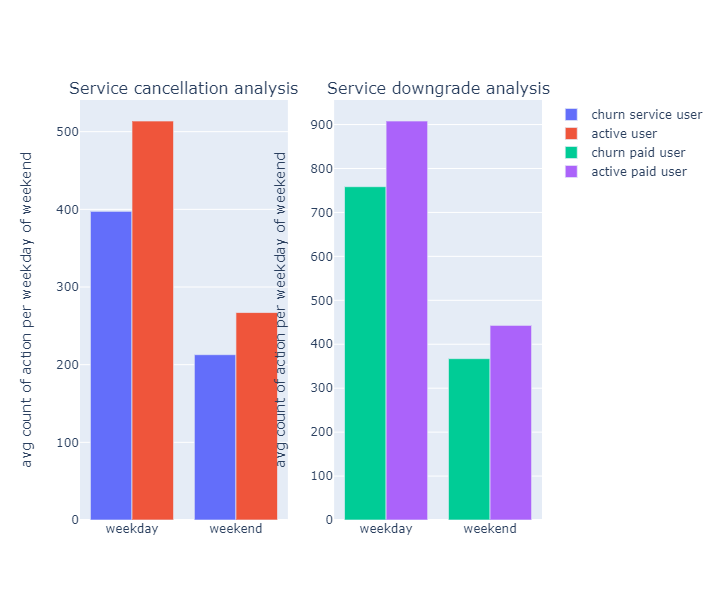

In [140]:
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=['Service cancellation analysis','Service downgrade analysis']
)

fig.append_trace(trace1,1,1)
fig.append_trace(trace2,1,1)
fig.append_trace(trace3,1,2)
fig.append_trace(trace4,1,2)

fig.layout.update(height=600, width=900, )
# fig.update_xaxes(
#     title_text = 'avg listen time'
# )
fig.update_yaxes(
    title_text = 'avg count of action per weekday of weekend'
)
fig.show()

###### 주말 vs 평일 비교 결과 
- 전체적으로 평일에 이용을 많이 한다 
- 서비스 ,유료 멤버쉽 이탈 유저들이 평균적으로 평일이나 주말이나 action의 횟수가 적다

In [141]:
# # set segmentation 
# filter_weekday = F.col('is_weekday') == 1
# filter_weekend = ~(filter_weekday)


action_week_no_churn = count_week_action.filter(filter_no_churn).toPandas()
action_week_churn_paid = count_week_action.filter(filter_churn_paid).toPandas()
action_week_churn_service = count_week_action.filter(filter_churn_service).toPandas()

In [142]:
# box plot unique 
# 1.churn_service vs active
# churn service
trace1 = go.Box(
    x=action_week_churn_service['count_action_week'].unique(),
    name='churned service user'
)
# active user
trace2 = go.Box(
    x=action_week_no_churn['count_action_week'].unique(),
    name='active user'
)

# 2. churn paid: churn_paid vs active paid
# churn_service_free_user
trace3 = go.Box(
    x=action_week_churn_paid['count_action_week'].unique(),
    name='churn paid ser'
)
trace4 = go.Box(
    x=action_week_no_churn[action_week_no_churn['level']=='paid']['count_action_week'].unique(),
    name='active paid user'
)

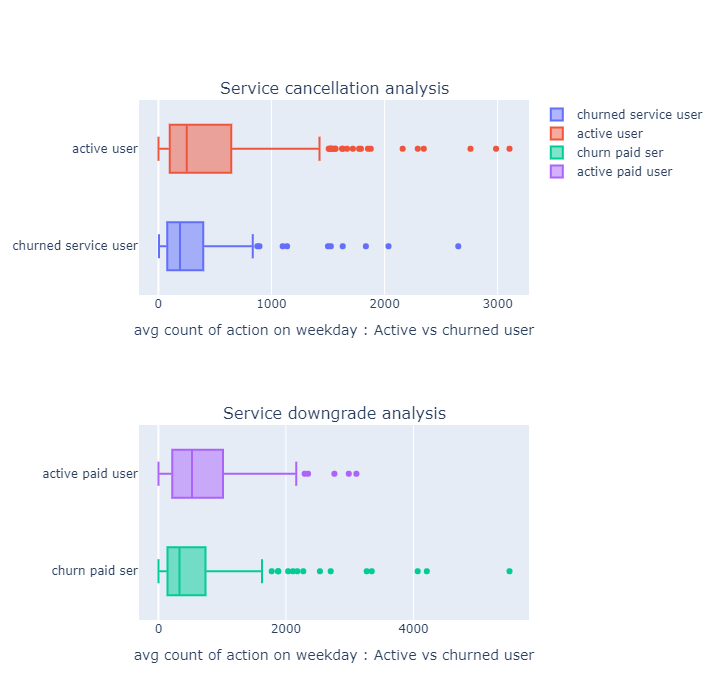

In [143]:
fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=['Service cancellation analysis','Service downgrade analysis']
)

fig.append_trace(trace1,1,1)
fig.append_trace(trace2,1,1)
fig.append_trace(trace3,2,1)
fig.append_trace(trace4,2,1)

fig.layout.update(height=700, width=700, )
fig.update_xaxes(
    title_text = 'avg count of action on weekday : Active vs churned user'
)
# fig.update_yaxes(
#     title_text = ''
# )
fig.show()

##### impact of the time between registration, upgrade and downgrade events
- 회원 가입 시간부터 최근 활동 시간까지의 기간 분석

In [144]:
# convert ts on registration 

regi_ts = (F.col('registration')/1000).cast('timestamp')

df_regi = df_clean.withColumn('regi_date',F.date_format(regi_ts,format='yyyy-MM-dd'))\
    .withColumn('regi_date',F.to_date(F.col('regi_date'),'yyyy-MM-dd'))\
        .withColumn('regi_year',F.year(F.col('date')))\
        .withColumn('regi_month',F.month(F.col('date')))\
        .withColumn('regi_day',F.dayofmonth(F.col('date')))\
        .withColumn('regi_hour', F.hour(regi_ts))\
        .withColumn('regi_dayofweek',F.dayofweek(F.col('date')))\
        .withColumn('regi_weekofyear',F.weekofyear(F.col('date')))

In [145]:
# add last_interaction , days_from_reg colu,n
df_from_reg = df_regi.filter(F.col('row_number')==1)\
    .groupby(['userId','level','churn_service','churn_paid','regi_date'])\
    .agg(F.max('date').alias('last_interaction'))\
    .withColumn('day_from_reg',F.datediff('last_interaction','regi_date'))

In [146]:
df_from_reg.orderBy('userId').show()

+------+-----+-------------+----------+----------+----------------+------------+
|userId|level|churn_service|churn_paid| regi_date|last_interaction|day_from_reg|
+------+-----+-------------+----------+----------+----------------+------------+
|    10| paid|            0|         0|2018-09-29|      2018-11-19|          51|
|   100| paid|            0|         1|2018-09-27|      2018-11-30|          64|
|100001| free|            1|         0|2018-08-19|      2018-10-03|          45|
|100002| paid|            0|         0|2018-06-25|      2018-12-03|         161|
|100003| free|            1|         0|2018-09-19|      2018-10-12|          23|
|100004| paid|            0|         2|2018-06-10|      2018-11-29|         172|
|100005| free|            1|         0|2018-07-26|      2018-10-20|          86|
|100006| free|            1|         0|2018-09-26|      2018-10-06|          10|
|100007| paid|            1|         0|2018-08-06|      2018-11-29|         115|
|100008| free|            0|

In [147]:
# box plot 

from_reg_no_churn = df_from_reg.filter(filter_no_churn).toPandas()
from_reg_churn_paid = df_from_reg.filter(filter_churn_paid).toPandas()
from_reg_churn_service = df_from_reg.filter(filter_churn_service).toPandas()

In [148]:
# avg 
print("Avg of day_from_reg: Active vs churned from service\n",\
     from_reg_no_churn['day_from_reg'].mean(), from_reg_churn_service['day_from_reg'].mean())
print("Avg of day_from_reg: Active paid vs churned from paid\n",\
     from_reg_no_churn[from_reg_no_churn['level']=='paid']['day_from_reg'].mean(), from_reg_churn_paid['day_from_reg'].mean())


Avg of day_from_reg: Active vs churned from service
 84.81203007518798 57.36538461538461
Avg of day_from_reg: Active paid vs churned from paid
 88.49438202247191 88.91836734693878


In [149]:
# box plot unique 
# 1.churn_service vs active
# churn service
trace1 = go.Box(
    x=from_reg_churn_service['day_from_reg'].unique(),
    name='churned service user'
)
# active user
trace2 = go.Box(
    x=from_reg_no_churn['day_from_reg'].unique(),
    name='active user'
)

# 2. churn paid: churn_paid vs active paid
# churn_service_free_user
trace3 = go.Box(
    x=from_reg_churn_paid['day_from_reg'].unique(),
    name='churn paid ser'
)
trace4 = go.Box(
    x=from_reg_churn_paid[from_reg_churn_paid['level']=='paid']['day_from_reg'].unique(),
    name='active paid user'
)

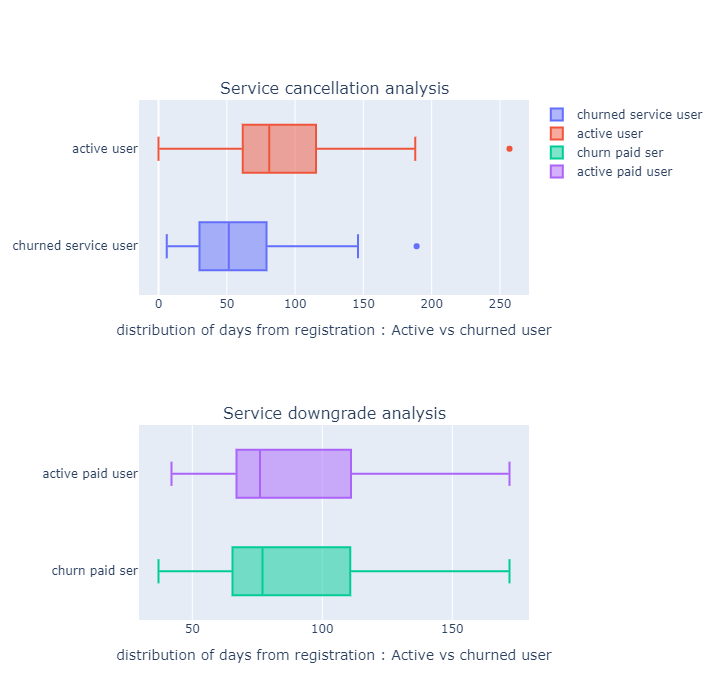

In [150]:
fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=['Service cancellation analysis','Service downgrade analysis']
)

fig.append_trace(trace1,1,1)
fig.append_trace(trace2,1,1)
fig.append_trace(trace3,2,1)
fig.append_trace(trace4,2,1)

fig.layout.update(height=700, width=700, )
fig.update_xaxes(
    title_text = 'distribution of days from registration : Active vs churned user'
)
# fig.update_yaxes(
#     title_text = ''
# )
fig.show()

day_from_reg 분석 결과 
- 서비스 이탈 유저는 가입한 시간으로부터 최근 활동시간까지의 기간이 짧다
- 유료 멤버십 이탈 유저와 활성화된 유료 유저와의 큰 차이는 없다

##### upgrade and downgrade
- from upgrade ~ downgrade_date
- from reg ~ to upgrade

#### from_reg ~ to upgrade
- 회원등록부터 유료결제 까지의 걸리는 평균 시간을 분석해본다
- 유료결제에서 유료 해지까지의 걸리는 평균 시간을 분석해본다


In [151]:
df_clean

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string, date: date, year: int, month: int, day: int, hour: int, dayofweek: int, weekofyear: int, regi_date: date, regi_year: int, regi_month: int, regi_day: int, regi_hour: int, regi_dayofweek: int, regi_weekofyear: int, state: string, cancelled: int, downgraded: int, upgraded: int, phase_downgrade: bigint, phase_upgrade: bigint, phase_cancel: bigint, churn_paid: bigint, churn_service: bigint, row_number: int]

In [152]:
### upgrade_df 

df_upgrade = df_regi.select(['userId','level','page','upgraded','phase_upgrade','churn_paid','churn_service','ts','date','regi_date'])\
    .filter(F.col('page')=='Submit Upgrade')\
    .filter(F.col('level')=='free').dropDuplicates()\
    .withColumn('reg_to_upgrade',F.datediff('date','regi_date'))\
    .withColumn('upgrade_date',F.col('date'))\
    .orderBy('userId',F.desc('phase_upgrade'),F.asc('date'))
    

In [153]:
windowval = Window.partitionBy('userId').orderBy(F.asc('ts'))
upgrade_user = df_upgrade.withColumn('row_number',F.row_number().over(windowval))

In [154]:
# row number == 1
upgrade_user = upgrade_user.filter(F.col('row_number')==1)

In [155]:
# upgrade segmentation 
upgrade_no_churn = upgrade_user.filter(filter_no_churn).toPandas()
upgrade_churn_paid = upgrade_user.filter(filter_churn_paid).toPandas()
upgrade_churn_service = upgrade_user.filter(filter_churn_service).toPandas()

In [156]:
# box plot unique 
# 1.churn_service vs active
# churn service
trace1 = go.Box(
    x=upgrade_churn_service['reg_to_upgrade'],
    name='churned service user'
)
# active user
trace2 = go.Box(
    x=upgrade_no_churn['reg_to_upgrade'],
    name='active user'
)

# 2. churn paid: churn_paid vs active paid
# churn_service_free_user
trace3 = go.Box(
    x=upgrade_churn_paid['reg_to_upgrade'],
    name='churn paid ser'
)


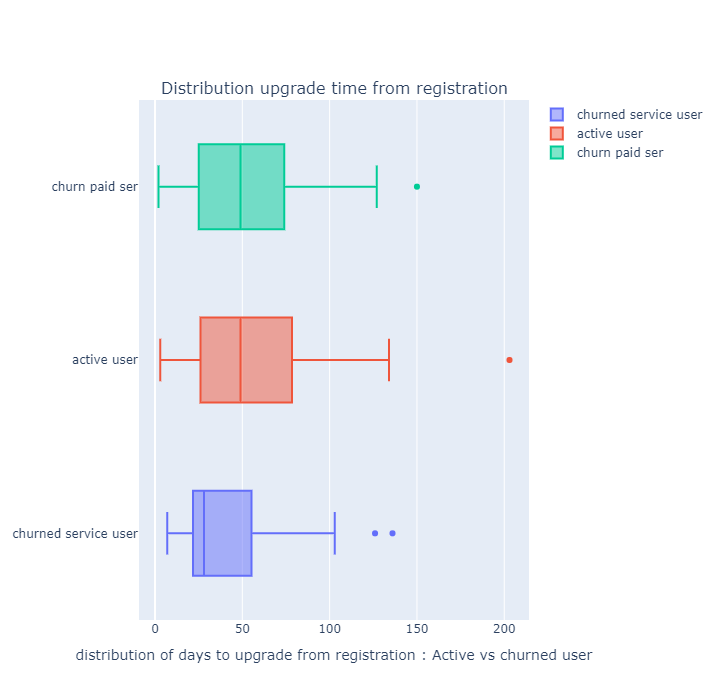

In [157]:
fig = make_subplots(
    rows=1, cols=1,
    subplot_titles=['Distribution upgrade time from registration']
)

fig.append_trace(trace1,1,1)
fig.append_trace(trace2,1,1)
fig.append_trace(trace3,1,1)
# fig.append_trace(trace4,2,1)

fig.layout.update(height=700, width=700, )
fig.update_xaxes(
    title_text = 'distribution of days to upgrade from registration : Active vs churned user'
)
# fig.update_yaxes(
#     title_text = ''
# )
fig.show()

from_registration_to_upgrade 결과:
- 서비스에서 이탈한 유저는 유료결제 멤버쉽에도 빠르게 반응 하는 경향이 있다 

In [158]:
df_upgrade.toPandas()

userId level            page  upgraded  phase_upgrade  churn_paid  \
0       100  free  Submit Upgrade         1              1           1   
1    100004  free  Submit Upgrade         1              3           2   
2    100004  free  Submit Upgrade         1              2           2   
3    100004  free  Submit Upgrade         1              1           2   
4    100009  free  Submit Upgrade         1              1           1   
..      ...   ...             ...       ...            ...         ...   
154      93  free  Submit Upgrade         1              1           0   
155      96  free  Submit Upgrade         1              1           1   
156      97  free  Submit Upgrade         1              1           0   
157      98  free  Submit Upgrade         1              1           0   
158      99  free  Submit Upgrade         1              1           0   

     churn_service             ts        date   regi_date  reg_to_upgrade  \
0                0  1542215545000  2018-11-15  2018-09-27              49   
1                0  1539577249000  2018-10-15  2018-06-10             127   
2                0  1539880189000  2018-10-19  2018-06-10             131   
3                0  1543328769000  2018-11-27  2018-06-10             170   
4                1  1539556743000  2018-10-15  2018-09-20              25   
..             ...            ...         ...         ...             ...   
154              0  1543332537000  2018-11-28  2018-09-21              68   
155              0  1543220659000  2018-11-26  2018-09-17              70   
156              0  1540840448000  2018-10-30  2018-09-04              56   
157              0  1540458609000  2018-10-25  2018-09-28              27   
158              0  1541302700000  2018-11-04  2018-07-17             110   

    upgrade_date  
0     2018-11-15  
1     2018-10-15  
2     2018-10-19  
3     2018-11-27  
4     2018-10-15  
..           ...  
154   2018-11-28  
155   2018-11-26  
156   2018-10-30  
157   2018-10-25  
158   2018-11-04  

[159 rows x 12 columns]

In [159]:
# create upgrade_downgrade dataframe
up_down_cols = ['userId','level','page','phase_upgrade','phase_downgrade','churn_paid','churn_service','date','ts']

df_up_down=df_regi.select(up_down_cols)\
    .filter((F.col('page')=='Submit Upgrade')|(F.col('page')=='Submit Downgrade'))\
    

In [160]:
# create next_date , next_action, up_to_downgrade column
windowval = Window.partitionBy('userId').orderBy(F.desc('ts'))

df_up_down = df_up_down.withColumn('next_date',lag('date',1).over(windowval))\
    .withColumn('next_action',lag('page',1).over(windowval))\
    .withColumn('up_to_downgrade',F.datediff('next_date','date'))

In [161]:
# customer segmentation 

# 1. churn_Service !=0
up_down_churn_paid = df_up_down.filter(filter_churn_paid).toPandas()
up_down_churn_service = df_up_down.filter(filter_churn_service).toPandas()

In [162]:
# box plot 
# box plot unique 

trace1 = go.Box(
    x=up_down_churn_service['up_to_downgrade'],
    name='churned service user'
)
# active user
trace2 = go.Box(
    x=up_down_churn_paid['up_to_downgrade'],
    name='churn paid user'
)



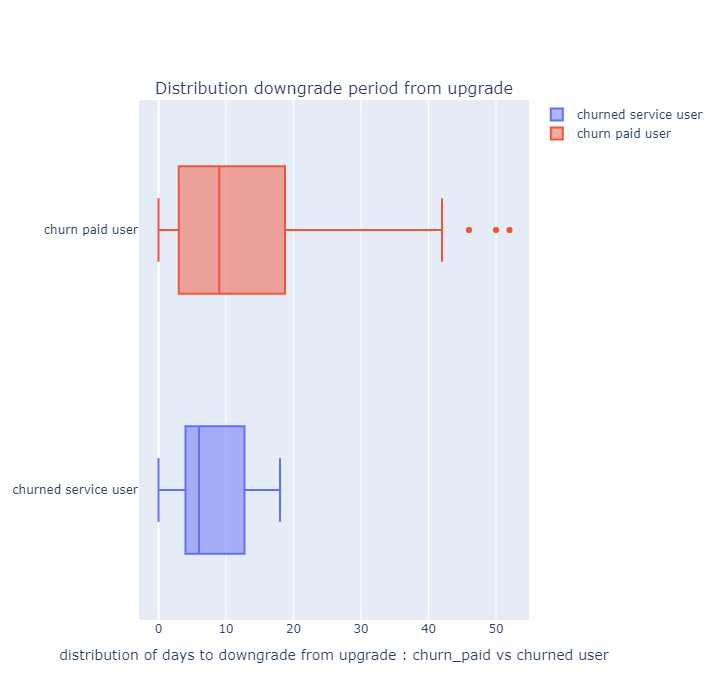

In [163]:
fig = make_subplots(
    rows=1, cols=1,
    subplot_titles=['Distribution downgrade period from upgrade']
)

fig.append_trace(trace1,1,1)
fig.append_trace(trace2,1,1)
# fig.append_trace(trace3,1,1)
# fig.append_trace(trace4,2,1)

fig.layout.update(height=700, width=700, )
fig.update_xaxes(
    title_text = 'distribution of days to downgrade from upgrade : churn_paid vs churned user'
)
# fig.update_yaxes(
#     title_text = ''
# )
fig.show()

from_upgrade to downgrade 결과
- 서비스에서 이탈하고, 유료멤버쉽에서 이탈한 유저가 짧은시간동안 빠르게 이용하고, 빠르게 서비스에서 이탈하는 
경향을 확인할 수 있다

In [164]:
def get_week_from_df(df, week_day_start, week_day_last):
    """
        Function to extract the rows corresponding to a given week
    """
    

    # filter by week day_start, week_day_last 
    filter_week = (F.col('date')>=week_day_start) &(F.col('date')<=week_day_last)
    
    # is_weekday or not 
    is_weekday = udf(lambda x:1 if x in ['1','2','3','4','5'] else 0, IntegerType())
    is_ads = udf(lambda x:1 if x == "Roll Advert" else 0, IntegerType())
    
    # apply filter_week 
    df_week = df.filter(filter_week).orderBy('ts',ascending=False)\
        .withColumn('is_weekday',is_weekday('dayofweek'))\
        .withColumn('is_ads',is_ads('page'))
    return df_week

##### week summary Class

    1. 주간별 노래, 아티스트 , 로긴, 광고 카운트 
    2. 주간별, 평일 카운트+ 주말 카운트
    3. 주간별 평균 
        - song count 
        - artist distinct count 
        - login count 
        - ads count 
        - song repeat
    4. 주간별 delta_login time 
    5. 주간별 listen_time session
    6. 주간별 num_actions_per_session
    

In [1]:
class WeekSummary:
    """
    
    """
    
    def __init__(self, df_week):
        # get df from given weeek
        self.df_week = df_week
        # get unique userId ,level
        self.users = self.get_users()
        # get week summary 
        self.week_summary = self.get_week_summary()
    
    def get_users(self):
        """
            Extract the list of unique combination of userId, level
        """
        service_users = self.df_week.select(['userId','level']).distinct()
        return service_users
    
    #last_interaction
    def get_last_interaction(self):
        """
            get last interaction date from user
        """
        df_last_time = self.df_week.groupby(['userId','level'])\
            .agg(F.max('ts').alias('last_interaction'))
        
        return df_last_time
    
    
    def compute_count_song(self):
        """
            extract the count of songs per user during week or weekend 
            1. total count of songs 
            2. total song per weekdays 
            3. total song per weekend
        """
        song_week = self.df_week.groupby(['userId','level'])\
            .agg(count('song').alias('count_song'))
        
        song_weekday = self.df_week.filter(F.col('is_weekday')==1)\
            .groupby(['userId','level'])\
            .agg(countDistinct('song').alias('count_song_weekday'))
    
        song_weekend = self.df_week.filter(F.col('is_weekday')!=1)\
            .groupby(['userId','level'])\
            .agg(countDistinct('song').alias('count_song_weekend'))
        
        return song_week, song_weekday, song_weekend
    
    def compute_count_artist(self):
        """
            extract the count of distinct artist listend to per user
        """
        artist_week = self.df_week.groupby(['userId','level'])\
            .agg(countDistinct('artist').alias('count_distinct_artist'))
        
        return artist_week
    
    def compute_count_login(self):
        """
            Extract the number of session per user
        """
        login_week = self.df_week.groupby(['userId','level'])\
            .agg(countDistinct('sessionId').alias('count_login'))
        
        
        return login_week
    
    def compute_count_ads(self):
        """
            Extract the number of ads listened to per user
        """
        ads_week = self.df_week.groupby(['userId','level'])\
            .agg(F.sum('is_ads').alias('count_ads'))
        
        return ads_week
    
    #get_last_interaction
    #compute_counts
    def compute_count_merge(self):
        """
            add column per count
        """
        df_count = self.users
        
        # add songs on weekdays and weekend 
        song_week, song_weekday, song_weekend = self.compute_count_song()
        
        df_count = df_count.join(song_week, on=['userId','level'], how='full')\
            .join(song_weekday, on=['userId','level'], how='full')\
            .join(song_weekend, on=['userId','level'], how='full')
        
        # add distinct artists 
        artist_week = self.compute_count_artist()
        df_count = df_count.join(artist_week, on=['userId','level'], how='full')
        
        # add login (unique sessionId?)
        login_week = self.compute_count_login()
        df_count = df_count.join(login_week, on=['userId','level'], how='full')
        
        # add ads
        ads_week = self.compute_count_ads()
        df_count = df_count.join(ads_week, on=['userId','level'], how='full')
        
        # repeat
        df_count = df_count.withColumn('count_repeat',F.col('count_song')-(F.col('count_song_weekday')+F.col('count_song_weekend')))
        
        return df_count
        
    def compute_delta_login(self):
        """
            Calculate avg delta time between two login in the given week
        """
        
        # set inwdow 
        window_login = Window.partitionBy(['userId']).orderBy(F.desc('ts'))
        
        # add new column next date 
        df_delta = self.df_week.withColumn('next_date',lag('date',1).over(window_login))
        
        # calculate delta betwwen two login
        df_delta = df_delta.withColumn('delta_time',F.datediff(F.col('next_date'),F.col('date')))
        
        # compute the avg delta_time between login for each user 

        delta_cols = ['userId','level','churn_service','churn_paid','delta_time']

        df_delta_login = df_delta.select(delta_cols)\
            .filter(df_delta_login['delta_time'] != 0)
        distinct_session = df_churn.groupby('userId').agg(F.countDistinct('sessionId').alias('user_num_session'))

        # join: df_delta_login + distinct_session
        df_delta_login = df_delta_login.join(distinct_session, on=['userId'], how='inner')

        # calculate avg delta time , total_avg_delta
        df_delta_login = df_delta_login.withColumn('avg_delta',F.col('delta_time')/F.col('user_num_session'))\
            .withColumn('total_avg_delta',F.sum('avg_delta').over(Window.partitionBy('userId')))
        
        # group by , relevant data 
        df_delta_login = df_delta_login.groupby(['userId','level'])\
            .agg(F.max('total_avg_delta').alias('time_inter_login'))
        
        
        return df_delta_login
    
    def compute_listen_session(self):
        """
            Calculate the average listening per session per user 
        """
        # window per user by desc timestmp
        window_user = Window.partitionBy("userId").orderBy(F.desc('ts'))
        #window per user, session
        window_session = Window.partitionBy(["userId","sessionId"]).orderBy("ts").rangeBetween(Window.unboundedPreceding,0)
        
        # add two new columns: next_ts, next_action
        df_listen_session = self.df_week.withColumn('next_ts',lag('ts',1).over(window_user))\
            .withColumn('next_action',lag('page',1).over(window_user))
        
        # calculate the diff between two timestamp
        df_listen_session = df_listen_session.withColumn("diff_ts",(F.col('next_ts').cast('integer')- F.col('ts').cast('integer'))/1000)
        
        # keep only the Nextsong action , filter 
        df_listen_session = df_listen_session.filter(F.col['page']=='NextSong')
        # add a column total listening 
        df_listen_session = df_listen_session.withColumn("listen_session",F.sum("diff_ts").over(window_session))
        
        # extract max value only for each session per user
        df_listen_session = df_listen_session.groupby(['userId','sessionId','level'])\
            .agg(F.max('listen_session').alias('total_listen_session'),\
                F.max('itemInSession').alias('item_session'))
        
        df_listen_session = df_listen_session.withColumn('avg_listen_session',
            F.round((F.col('total_list_session')/F.col('item_session'))/60,2))                                            
        
        # add a column with total number of session , avg_listen_time per session
        num_session = self.df_week.groupby(['userId','level'])\
            .agg(countDistinct('sessionId').alias('num_session'))
        
        df_listen_session = df_listen_session.join(num_session, on=['userId','level'], how='full')
        
        df_listen_session = df_listen_session.withColumn("week_total_listen",
                            F.sum('avg_listen_session').over(Window.partitionBy('userId')))\
            .withColumn('avg_listen_time_session',F.round((F.col('week_total_listen')/F.col('num_session')),2))
        
        # keep relevant columns and distinct 
        df_listen_session = df_listen_session.select(['userId','level','avg_listen_time_session']).distinct()
    
        return df_listen_session
        
        
    def compute_action_session(self):
        """
            calculate the avg number of action per session per user for the given week
        """
        
        window_user = Window.partitionBy("userId").orderBy('ts',ascending=False)
        window_session = Window.partitionBy(['userId','sessionId']).orderBy('ts').rangeBetween(Window.unboundedPreceding,0)
        
        #
        df_action_session = df_week.groupby(['userId','level','sessionId'])\
            .agg(F.count('page').alias('action_per_session'))
        df_action_session = df_action_session.withColumn('total_action_week',\
                                        F.sum('action_per_session').over(Window.partitionBy('userId')))
        
        # add column with total number of session in the week 
        
        num_session = df_week.groupby(['userId','level'])\
            .agg(F.countDistinct('sessionId').alias('num_session'))
        
        df_action_session = df_action_session.join(num_session, on=['userId','level'], how='full')
        
        df_action_session = df_action_session.withColumn('avg_num_action_session',\
                                        F.round(F.col('total_action_week')/F.col('num_session')),2)
        
        # keep only the relevant columns 
        df_action_session = df_action_session.select(['userId','level','avg_num_action_session']).distinct()
        
        return df_action_session
    
    
    def compute_avg(self):
        """
            Add a columns per avg to avg_df one row per user for the given week
        """
        
        # only specific user dataframe
        df_user_avg = self.users
        
        # delta time between login
        df_delta_login = self.compute_delta_login()
        df_user_avg = df_user_avg.join(df_delta_login, on=['userId','level'], how='full')
        
        # time per session
        df_listen_session = self.compute_listen_session()
        df_user_avg = df_user_avg.join(df_listen_session, on=['userId','level'], how='full')
        
        # action per session
        df_action_session = self.compute_action_session()
        df_user_avg = df_user_avg.join(df_action_session, on=['userId','level'], how='full')
        
        return df_user_avg
    
    #replace_na
    def replace_na(self, df):
        """
            Sets default values for null values when calculating count and average
        """
        # replace null value of time_inter_login to 7 (number of days 7)
        df_filled = df.na.fill({'time_inter_login':'7'})
        df_filled = df_filled.na.fill(0)
        
        return df_filled
    
    
    
    def get_week_summary(self):
        """
            여기서 최종적으로 week_summary준다 
            1. last_interaction time
            2. count(song, ads,login, artist distcint, song repeat)
            3. avg()
            4. join(df_avg,on=['userId','level'])
            5. after join, replace nan value
        """
        # 최근 활동시간 
        week_last_interaction = self.get_last_interaction()
        # 여러가지 count 
        week_summary_count = self.compute_count_merge()
        # join
        week_summary = week_last_interaction.join(week_summary_count, on=['userId','level'], how='full')
        # avg 
        week_summary_avg = self.compute_avg()
        # summary.join(avg)
        week_summary = week_summary.join(week_summary_avg, on=['userId','level'], how='full')
        # replace nan value 
        week_summary = self.replace_na(week_summary)
        
        return week_summary

#### UserSummary:
    - 매주 새롭게 이벤트 데이터가 들어오므로 
        => 기존의 summary에서 update summary로 업데이트 하는 
    - 
    - 
    - 
    

In [2]:
class UserSummary:
    """
    
    """
    
    def __init__(self, df, table_name):
        self.df = df 
        self.table_name = table_name
        self.user_summary = None
    
    def create_column_with_type(self,column_list, target_type):
        """
            Convert Type on column_list to target_type
        """
        for column in column_list:
            df = self.df.withColumn(column,lit(None))\
                .withColumn(column, F.col(column).cast(target_type))

        return df
    
    def load_summary(self):
        """
            Load existing summary. if there is no existing table, create empty dataframe with specified column type.
        """
         try:
            loaded_summary = spark.read.parquet('./spark-warehouse/{}'.format(self.table_name))
            return loaded_summary
        
        except:
            # create an empty dataframe 
            # 1. using StructField 
            user_summary = spark.createDataFrame([],StructType([]))
            
            str_cols = ['userId','level','gender','state','last_interaction']
            int_cols = ['churn_service','churn_paid','count_song','count_song_weekday','count_song_weekend','count_distinct_artist','count_login','count_ads','count_repeat','day_from_reg']
            float_cols = ['time_inter_login','avg_listen_time_session','avg_num_action_session']
            
            # apply create_column_type
            user_summary = create_column_with_type(user_summary,str_cols,StringType())
            user_summary = create_column_with_type(user_summary,int_cols,IntegerType())
            user_summary = create_column_with_type(user_summary,float_cols,FloatType())
            # 2. columns = []
            # schema= StructType(columns)
            #. user_summary = spark.createDataFrame(data=[],schema=schema)
            # convert_type, integeer_cols, string_cols, float_cols
            
            
            return user_summary
    
    def save_summary(self,mode=""):
        """
            Save summary as data warehouse
        """
        self.user_summary.write\
            .mode(mode)\
            .parquet("./spark-warehouse/{}".format(self.table_name))
        
        print("Saved summary!")
        
    
    # update 1.day_from_reg
    def compute_day_from_reg(self, updated_summary):
        """
            Computes day from reg using last_interaction
        """
        regi_summary = self.df.select(['userId','level','regi_date']).distinct()
        
        #join input_df + reg_summary
        updated_summary = updated_summary.join(regi_summary,on=['userId','level'])
        
        # calculate day_from_reg, with F.datediff().
        updated_summary = updated_summary.withColumn('day_from_reg',\
                                                    F.datediff('last_interaction','regi_date'))
        
        # drop regi_date
        updated_summary = updated_summary.drop('regi_date')
        
        return updated_summary 
    
    
    # init_user_summary 
    def init_user_summary(self, updated_summary):
        """
            create 'day_from_registration' column using compute_day_from_reg function
        """
        updated_summary = self.compute_day_from_reg(updated_summary)
        
        return updated_summary
    
    def get_last_summary(self):
        """
            return last version of the summary(version saved) and rename the columns
        """
        # rename으로 구분
        
        user_summary = self.user_summary.createOrReplaceTempView("user_summary")
        user_summary = spark.sql("SELECT * FROM user_summary")
        
        last_user_summary = spark.sql("""
            SELECT * FROM (
                SELECT *, MAX(last_interaction) OVER (PARTITION BY userId,level) AS max_last FROM user_summary
            ) table1 \
            WHERE last_interaction = table1.max_last
        """)
        
        # rename count_cols => last_count_cols 
        count_cols =['count_song','count_song_weekday','count_song_weekend',\
                    'count_distinct_artist','count_login','count_ads','count_repeat',\
                    'time_inter_login','avg_listen_time_session','avg_num_action_session']
        # for loop
        # apply rename column
        for col in count_cols:
            last_user_summary = last_user_summary.withColumnRenamed(col, 'last_{}'.format(col))
            
        return last_user_summary
    
    # update old summary 
    def update_old_summary(self, updated_summary):
        """
            Appends new rows for each user for the next week, to prev loaded summary.
            
        """
        last_user_summary = self.get_last_summary()
        
        # drop last cols
        drop_old_cols = ['last_interaction','gender','state','churn_service','churn_paid','max_last']
        last_user_summary = last_user_summary.drop(drop_old_cols)
        
        # split the user_summary into 2df: one with knownuser, one with new user 
        # for new user, apply instantiation of the summary 
        new_user_summary = updated_summary.join(last_user_summary, on=['userId','level'],\
                                               how='left_anti')
        
        new_user_summary = new_user_summary.select(['userId','level','last_interaction',\
                                                   'count_song','count_song_weekday','count_song_weekend',\
                                                   'count_distinct_artist','count_login','count_ads','count_repeat',\
                                                   'time_inter_login','avg_listen_time_session','avg_num_action_session',\
                                                   'gender','state','churn_service','churn_paid'])
        
        # create new user summary  with calculatting day_from_reg
        new_user_summary = self.init_user_summary(user_summary_new)
        
        # for old user too, day_from_reg
        old_user_summary = updated_summary.join(last_user_summary, on=['userId','level'],how='inner')
        
        # drop column last_{} count column 
        count_cols = ['count_song', 'count_song_weekday', 'count_song_weekend',\
                     'count_distinct_artist', 'count_login', 'count_ads', 'count_repeat',\
                     'time_inter_login', 'avg_listen_time_session', 'avg_num_action_session']
        
        for column in count_cols:
            last_count_col='last_{}'.format(column)
            old_user_summary = old_user_summary.drop(last_count_col)
        
        # add day_from_reg column 
        old_user_summary = self.compute_time_from_reg(old_user_summary)
        
        # union new + old
        updated_summary = old_user_summary.union(new_user_summary)
        
        return udpated_summary
      
    # final update
    def update_user_summary(self, week_sum):
        """
            update user summary, compute again day from registration and last_interaction
        """
        week_sum = week_sum.createOrReplaceTempView("week_sum")
        week_sum = spark.sql("SELECT * FROM week_sum")
        
        # instantiate the update
        user_info = self.df.select(['userId','level','gender','state','churn_service','churn_paid']).distinct()
        updated_summary = week_sum.join(user_info, on=['userId','level'], how='inner')
        
        # load the existing summary 
        user_summary = self.load_summary()
        self.user_summary = user_summary
        
        if self.user_summary.count() >0:
            # compute updated counts 
            new_user_summary = self.updated_old_summary(updated_summary)
            self.user_summary = new_user_summary 
            
            # append save 
            self.save_summary('append')
        else:
            # no count, first week?
            
            updated_summary = self.init_user_summary(updated_summary)
            self.user_summary = updated_summary 
            
            self.save_summary('overwrite')

##### MonthSummary; 
    -
    - 
    - 
    -
    -
    -
    